# Response Curves in MMM

Slava Kisilevich
kisilevich.slava@gmail.com

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import pandas as pd
import numpy as np
import math
import sys
import os

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['font.size'] = 18
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [4]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import shap
shap.initjs()

In [5]:
from prophet import Prophet

In [6]:
import optuna as opt
from functools import partial

## Helper Functions

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed
    
    
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        if slope_s < 0 or half_saturation_k < 0:
            raise ValueError("slope_s and half_saturation_k must be non-negative")
                             
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        self.epsilon = 1e-9  # small constant value to avoid division by zero
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / (X**self.slope_s + self.epsilon))**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / (x_point**self.slope_s + self.epsilon))**-1
            

## Data

In [8]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [9]:
holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [10]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [11]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [12]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

13:48:01 - cmdstanpy - INFO - Chain [1] start processing
13:48:01 - cmdstanpy - INFO - Chain [1] done processing


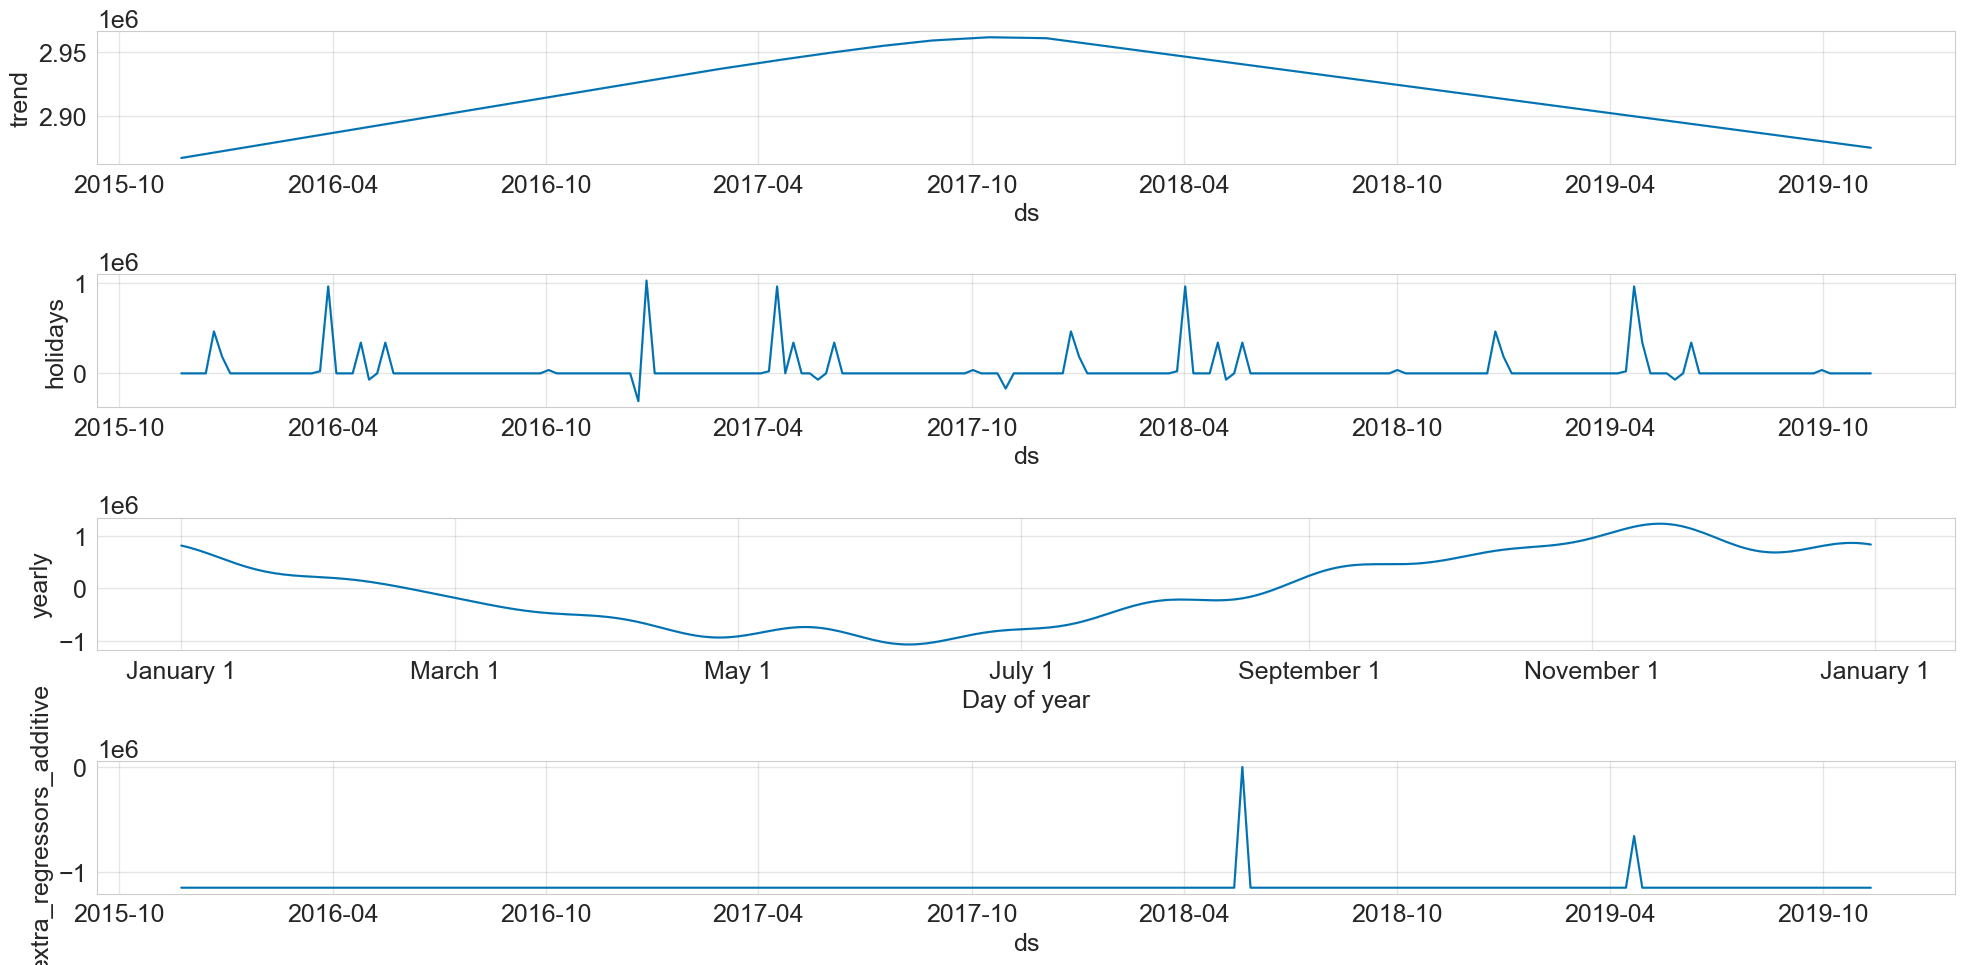

In [13]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [14]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [15]:
data = final_data.copy()

## Modeling Ridge Regression

In [16]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 hill_slopes_params, 
                 hill_half_saturations_params, 
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}
    hill_slopes = {}
    hill_half_saturations = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        hill_slope_param = f"{feature}_hill_slope"
        min_, max_ = hill_slopes_params[hill_slope_param]
        hill_slope = trial.suggest_float(f"hill_slope_{feature}", min_, max_)
        hill_slopes[feature] = hill_slope
        
        hill_half_saturation_param = f"{feature}_hill_half_saturation"
        min_, max_ = hill_half_saturations_params[hill_half_saturation_param]
        hill_half_saturation = trial.suggest_float(f"hill_half_saturation_{feature}", min_, max_)
        hill_half_saturations[feature] = hill_half_saturation
        
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        #hill saturation transformation
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_temp[feature] = temp_hill_saturation
        
        
    #Ridge parameters
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10000)
    scores = []
    
    #cross validation
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #params of Ridge Regression
        params = {"alpha": ridge_alpha}
        
        ridge = linear_model.Ridge(alpha = ridge_alpha, random_state=0)
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("hill_slopes", hill_slopes)
    trial.set_user_attr("hill_half_saturations", hill_half_saturations)
    
    
    #average of all scores    
    return np.mean(scores)

In [17]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    hill_slopes_params, 
                    hill_half_saturations_params, 
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")

    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    hill_slopes_params = hill_slopes_params, 
                                    hill_half_saturations_params = hill_half_saturations_params, 
                                    tscv = tscv, 
                                    )
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

### Features and parameters

In [18]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
control_features = ["trend", "season", "holiday", "competitor_sales_B", "events"]
features = control_features + media_channels + organic_channels


tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

adstock_features_params = {
    "tv_S_adstock": (0.3, 0.8),
    "ooh_S_adstock": (0.1, 0.4),
    "print_S_adstock": (0.1, 0.4),
    "facebook_S_adstock": (0.1, 0.4),
    "search_S_adstock": (0.1, 0.4),
    "newsletter_adstock": (0.1, 0.4),
}
hill_slopes_params = {
    "tv_S_hill_slope": (0.1, 5.0),
    "ooh_S_hill_slope": (0.1, 5.0),
    "print_S_hill_slope": (0.1, 5.0),
    "facebook_S_hill_slope": (0.1, 5.0),
    "search_S_hill_slope": (0.1, 5.0),
    "newsletter_hill_slope": (0.1, 5.0),
}
hill_half_saturations_params = {
    "tv_S_hill_half_saturation": (0.1, 1.0),
    "ooh_S_hill_half_saturation": (0.1, 1.0),
    "print_S_hill_half_saturation": (0.1, 1.0),
    "facebook_S_hill_half_saturation": (0.1, 1.0),
    "search_S_hill_half_saturation": (0.1, 1.0),
    "newsletter_hill_half_saturation": (0.1, 1.0),
}
OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             hill_slopes_params = hill_slopes_params,
                             hill_half_saturations_params = hill_half_saturations_params,
                             tscv = tscv)

data size: 208
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
np.mean(experiment.best_trial.user_attrs["scores"]), experiment.best_trial.user_attrs["scores"]

(27643.683441858495, [39949.51069045248, 15337.85619326451])

In [20]:
#ridge regression param
experiment.best_trial.user_attrs["params"]

{'alpha': 3.8031081284549577}

In [21]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.4220788437765558,
 'ooh_S': 0.10019099066044604,
 'print_S': 0.24678666680117614,
 'facebook_S': 0.38448799550469326,
 'search_S': 0.1405168971027844,
 'newsletter': 0.3515565832936356}

In [22]:
experiment.best_trial.user_attrs["hill_slopes"]

{'tv_S': 2.4213528083003073,
 'ooh_S': 3.0028976949766872,
 'print_S': 1.2721368373635555,
 'facebook_S': 2.866151704282617,
 'search_S': 2.9835542470454914,
 'newsletter': 4.682089869468846}

In [23]:
experiment.best_trial.user_attrs["hill_half_saturations"]

{'tv_S': 0.16676425360037037,
 'ooh_S': 0.5279674468947023,
 'print_S': 0.43018952182884856,
 'facebook_S': 0.10101864512631238,
 'search_S': 0.8021512403602804,
 'newsletter': 0.44808865884661675}

### Model Refit

In [24]:
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                hill_slopes_params,
                hill_half_saturations_params,
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params


    #apply adstock transformation

    temporal_features = [feature if feature not in media_channels and feature not in organic_channels else f"{feature}_hill" for feature in features]

    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha:0.3}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)

        hill_slope = hill_slopes_params[feature]
        hill_half_saturation = hill_half_saturations_params[feature]
        print(f"applying saturation hill transformation on {feature} with saturation slope {hill_slope:0.3} and half saturation {hill_half_saturation:0.3}")

        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_refit[f"{feature}_adstock"] = temp_adstock
        data_refit[f"{feature}_hill"] = temp_hill_saturation

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[:end_index][temporal_features].copy()
    y_true_all = data[target].values[:end_index]

    #build ridge using the best parameters
    model = linear_model.Ridge(random_state=0, **best_params)
    model.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    #transformed data
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)} instances")
    prediction = model.predict(x_input_interval_transformed)

    #non transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    return {
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval,
            "model": model,
            "model_train_data": x_input,
            "model_data": data_refit, 
            "model_features": temporal_features, 
            "features": features
           }
    

In [25]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params_best = experiment.best_trial.user_attrs["adstock_alphas"]
hill_slopes_params_best = experiment.best_trial.user_attrs["hill_slopes"]
hill_half_saturations_params_best = experiment.best_trial.user_attrs["hill_half_saturations"]

result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params_best, 
                     hill_slopes_params=hill_slopes_params_best,
                     hill_half_saturations_params=hill_half_saturations_params_best,
                     start_index = 0, 
                     end_index = data.shape[0])

applying geometric adstock transformation on tv_S with alpha 0.422
applying saturation hill transformation on tv_S with saturation slope 2.42 and half saturation 0.167
applying geometric adstock transformation on ooh_S with alpha 0.1
applying saturation hill transformation on ooh_S with saturation slope 3.0 and half saturation 0.528
applying geometric adstock transformation on print_S with alpha 0.247
applying saturation hill transformation on print_S with saturation slope 1.27 and half saturation 0.43
applying geometric adstock transformation on facebook_S with alpha 0.384
applying saturation hill transformation on facebook_S with saturation slope 2.87 and half saturation 0.101
applying geometric adstock transformation on search_S with alpha 0.141
applying saturation hill transformation on search_S with saturation slope 2.98 and half saturation 0.802
applying geometric adstock transformation on newsletter with alpha 0.352
applying saturation hill transformation on newsletter with satu

In [26]:
#different parameters
result.keys()

dict_keys(['x_input_interval_nontransformed', 'x_input_interval_transformed', 'prediction_interval', 'y_true_interval', 'model', 'model_train_data', 'model_data', 'model_features', 'features'])

In [27]:
#features used during modeling
result["model_features"]

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S_hill',
 'ooh_S_hill',
 'print_S_hill',
 'facebook_S_hill',
 'search_S_hill',
 'newsletter_hill']

In [28]:
result["model"].intercept_

-2271606.2326227273

In [29]:
#save feature coefficients 
feature_coefficients = {}
for feature, model_feature, coef in zip(result["features"], result["model_features"], result["model"].coef_):
    feature_coefficients[feature] = coef
    print(f"feature: {feature} -> coefficient {coef}")

feature: trend -> coefficient 0.8562025037229944
feature: season -> coefficient 0.1482881761945581
feature: holiday -> coefficient 1.0272772858437156
feature: competitor_sales_B -> coefficient 0.2590518036843919
feature: events -> coefficient 1.0730741066486977
feature: tv_S -> coefficient 185985.96299691053
feature: ooh_S -> coefficient 74239.54397737015
feature: print_S -> coefficient 121996.29684498624
feature: facebook_S -> coefficient 18321.261748018685
feature: search_S -> coefficient 2375.9674577565793
feature: newsletter -> coefficient 67481.1492953842


In [30]:
#data used for modeling
result["model_data"].head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,...,ooh_S_adstock,ooh_S_hill,print_S_adstock,print_S_hill,facebook_S_adstock,facebook_S_hill,search_S_adstock,search_S_hill,newsletter_adstock,newsletter_hill
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,...,0,0.00000,95463.66667,0.46518,228213.98744,0.98870,0,0.00000,19401.65385,0.00524
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,...,0,0.00000,23559.16010,0.12791,122004.11209,0.93561,31000,0.01633,21611.77914,0.00866
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,...,248022,0.11120,9218.08659,0.04256,174600.37784,0.97596,32756,0.01920,22141.76323,0.00969
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,...,24849,0.00012,134874.90086,0.57448,151146.46959,0.96409,36502,0.02632,10584.08263,0.00031
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,...,522494,0.53963,33285.32722,0.18545,78801.48128,0.80587,32229,0.01831,19198.90393,0.00499


### Metrics

In [31]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_final= mean_absolute_percentage_error(result["y_true_interval"], result["prediction_interval"])
print(f'RMSE: {rmse_metric}')
print(f"MAPE: {mape_final:0.3}")

RMSE: 151280.50732830892
MAPE: 0.0496


RMSE: 151280.50732830892
MAPE: 0.04959676491217429


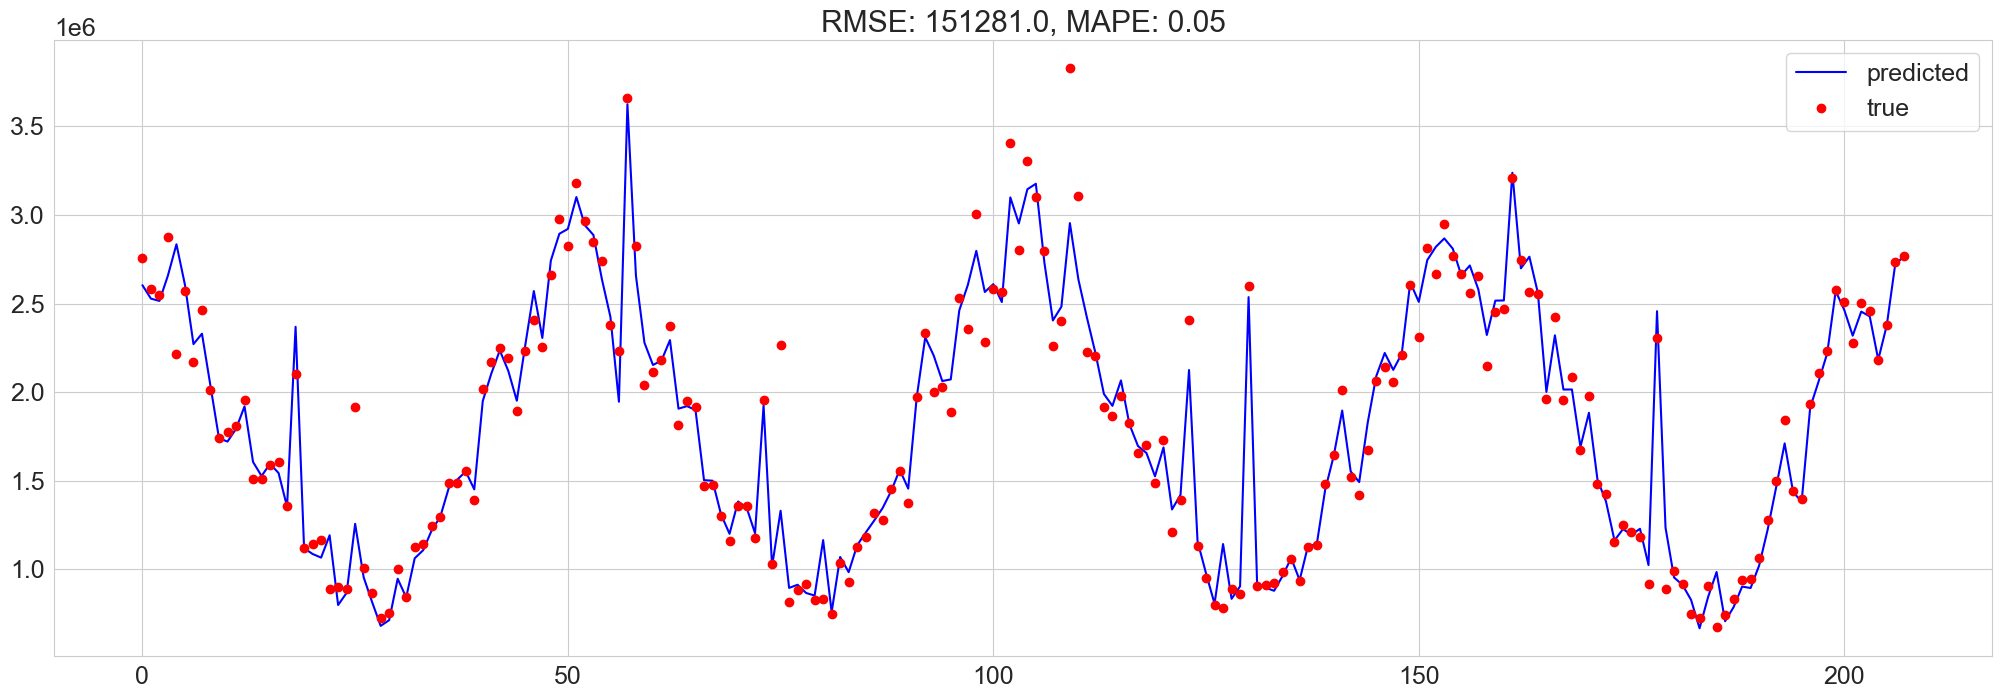

In [32]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])


print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')



fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}")
_ = ax.legend()

In [80]:
def format_thousands_millions(x, pos) -> str:
    if abs(x) >= 1e6:
        return "{:.1f}M".format(x * 1e-6)
    elif abs(x) >= 1e3:
        return "{:.1f}K".format(x * 1e-3)
    else:
        return "{:.1f}".format(x)
    
def plot_spend_response_curve(channel, spend_response_df, average_spend=0, average_response=0, optimized_spend=None, optimized_response=None, figure_size=(15, 6)):

    average_spend_response_df = pd.DataFrame({
        'average_spend': [average_spend], 
        'average_response': [average_response]
    })

    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    sns.scatterplot(data=average_spend_response_df, x='average_spend', y='average_response', color='blue', s=100)
    plt.axvline(x=average_spend_response_df['average_spend'][0], linestyle='dotted', alpha=0.5)
    plt.axhline(y=average_spend_response_df['average_response'][0], linestyle='dotted', alpha=0.5)

    #plt.xticks(ticks=range(0, int(max(spend_response_df["spend"])), 50_000)) 
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    
    
    
    if optimized_spend is not None and optimized_response is not None:
        optimized_spend_response_df = pd.DataFrame({
            'optimized_spend': [optimized_spend], 
            'optimized_response': [optimized_response]
        })
        sns.scatterplot(data=optimized_spend_response_df, x='optimized_spend', y='optimized_response', color='green', s=150)
        plt.axvline(x=optimized_spend_response_df['optimized_spend'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.axhline(y=optimized_spend_response_df['optimized_response'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.title(f"{channel}: Response curve, mean and optimized spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}\nOptimized Spend: {optimized_spend:.3f}\nOptimized Response: {optimized_response:.3f}")
    else:
        plt.title(f"{channel}: Response curve and mean spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}")

    plt.legend()
    plt.show()


def plot_multiple_spend_response_curves(spend_response_df, figure_size=(15, 6)):
    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response', hue='media_channel', style='media_channel')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    plt.title('Response curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
            
    plt.show()

In [34]:
feature_coefficients

{'trend': 0.8562025037229944,
 'season': 0.1482881761945581,
 'holiday': 1.0272772858437156,
 'competitor_sales_B': 0.2590518036843919,
 'events': 1.0730741066486977,
 'tv_S': 185985.96299691053,
 'ooh_S': 74239.54397737015,
 'print_S': 121996.29684498624,
 'facebook_S': 18321.261748018685,
 'search_S': 2375.9674577565793,
 'newsletter': 67481.1492953842}

### Generate Response Curves using Hill Saturation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tv_S
	tv_S: adstock: 0.4220788437765558
	tv_S: saturation slope: 2.4213528083003073
	tv_S: half saturation k: 0.16676425360037037
	tv_S: coefficient: 185985.96299691053
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average spending including weeks of no-spend: 118059.38649061784


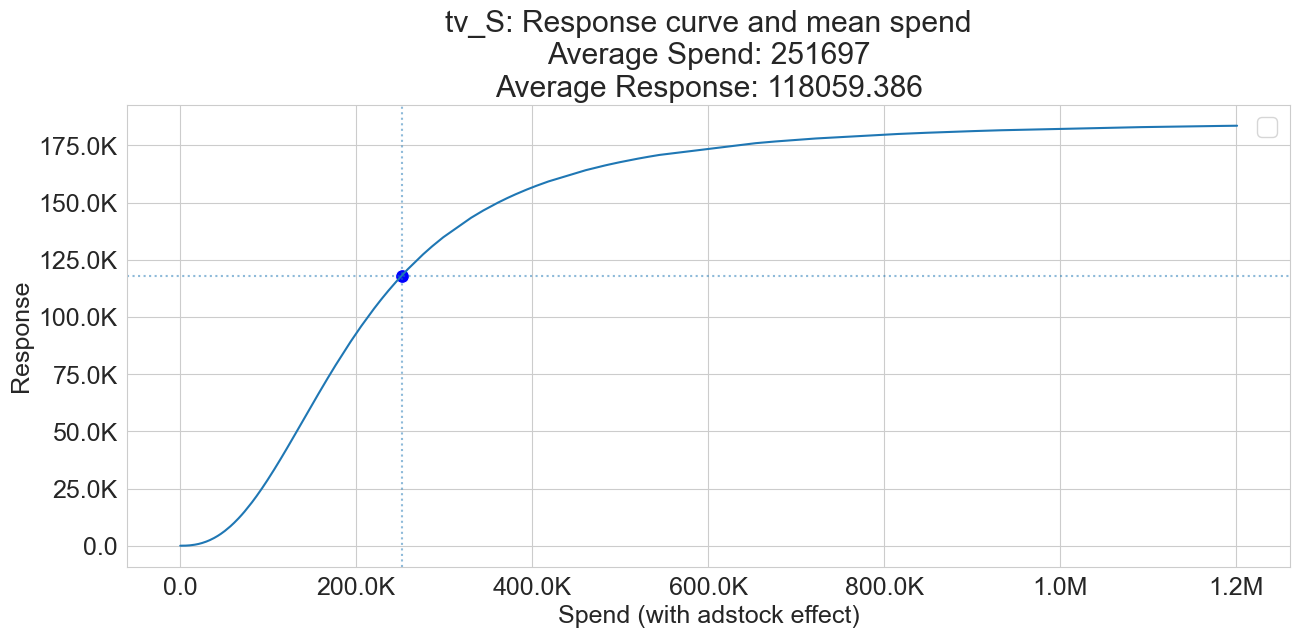

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
ooh_S
	ooh_S: adstock: 0.10019099066044604
	ooh_S: saturation slope: 3.0028976949766872
	ooh_S: half saturation k: 0.5279674468947023
	ooh_S: coefficient: 74239.54397737015
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average spending including weeks of no-spend: 4458.585754661308


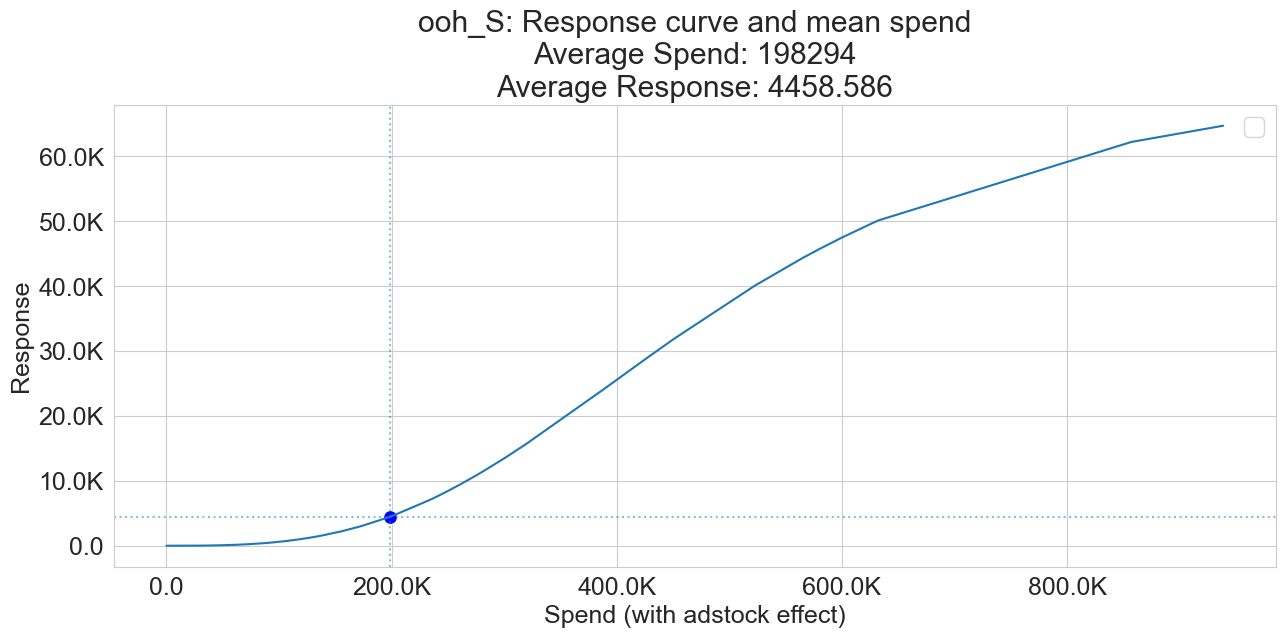

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
print_S
	print_S: adstock: 0.24678666680117614
	print_S: saturation slope: 1.2721368373635555
	print_S: half saturation k: 0.43018952182884856
	print_S: coefficient: 121996.29684498624
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.333333333
	average response corresponding to the average spending including weeks of no-spend: 43434.95799572923


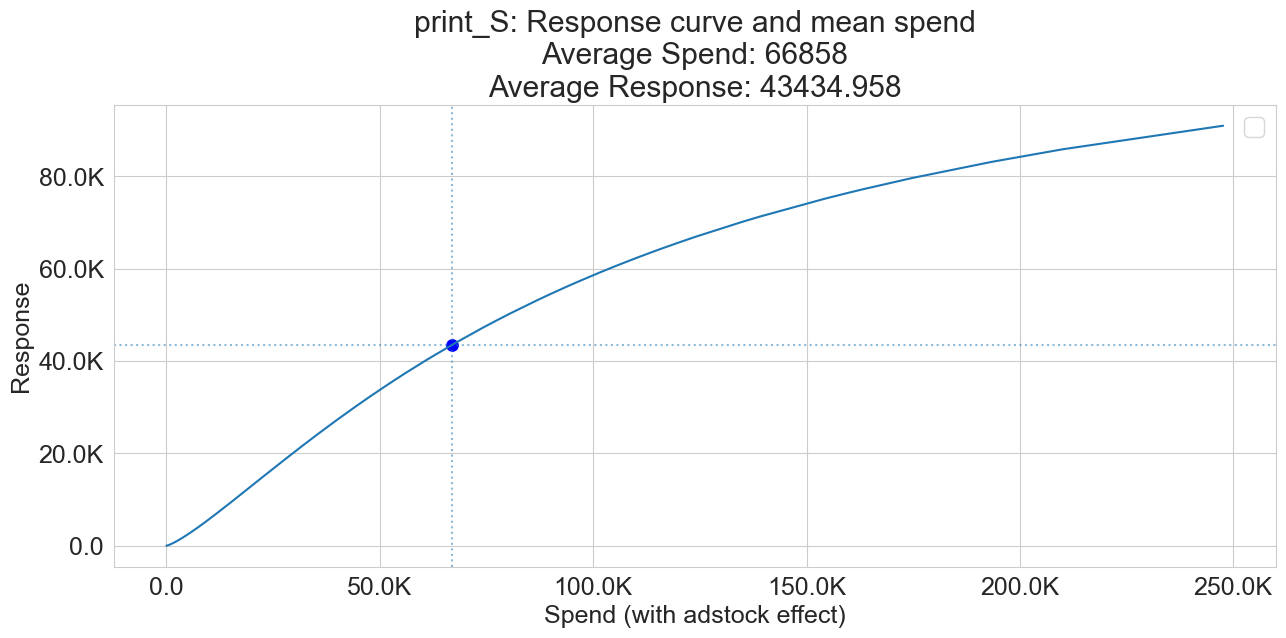

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
facebook_S
	facebook_S: adstock: 0.38448799550469326
	facebook_S: saturation slope: 2.866151704282617
	facebook_S: half saturation k: 0.10101864512631238
	facebook_S: coefficient: 18321.261748018685
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.742240227
	average response corresponding to the average spending including weeks of no-spend: 17378.509677936894


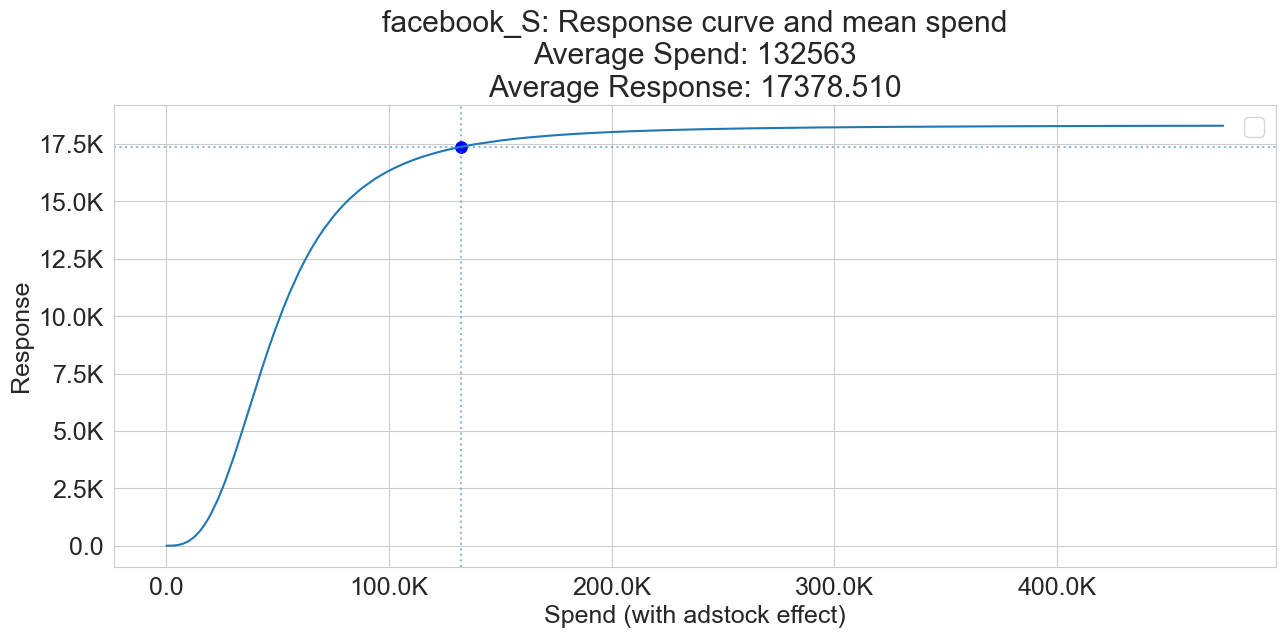

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
search_S
	search_S: adstock: 0.1405168971027844
	search_S: saturation slope: 2.9835542470454914
	search_S: half saturation k: 0.8021512403602804
	search_S: coefficient: 2375.9674577565793
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average spending including weeks of no-spend: 175.28344672260857


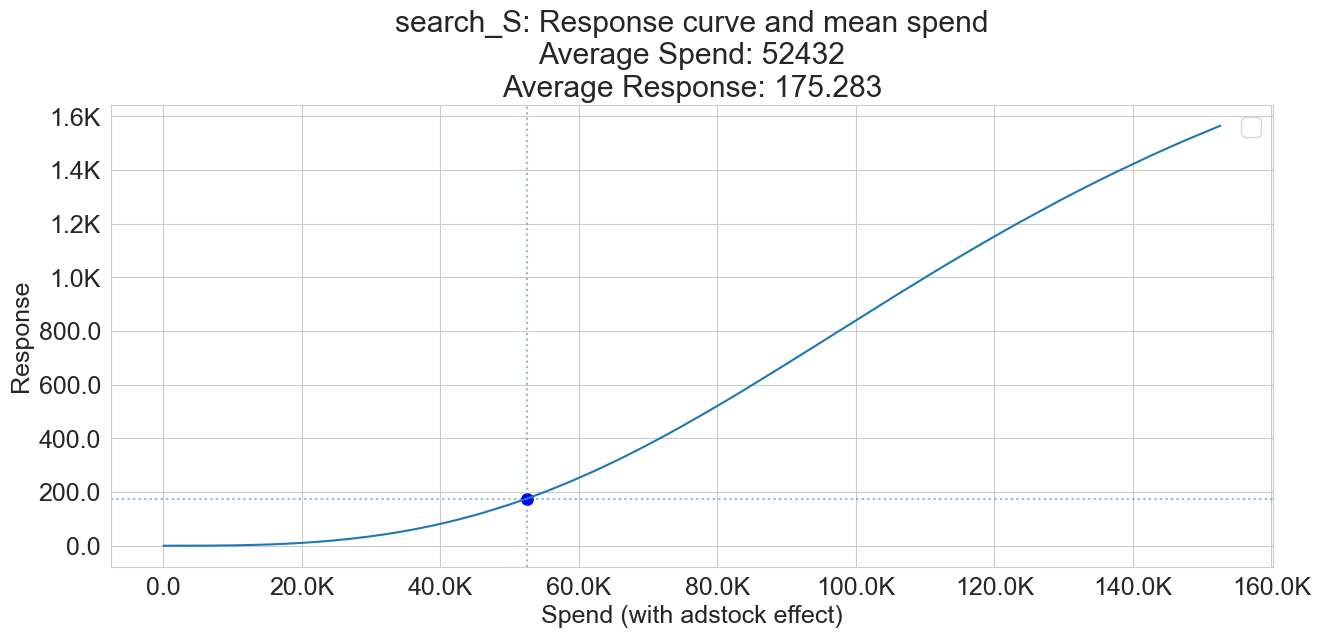

None


In [81]:
#dataframe for budget allocation
media_spend_response_data = []

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for media_channel in media_channels:
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_nonzero_spending)
    print(f"\taverage response corresponding to the average spending including weeks of no-spend: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
    
    plot = plot_spend_response_curve(media_channel, spend_response_temp_df, average_spend = average_nonzero_spending, average_response = average_response)
    print(plot)
    

media_spend_response_data = pd.concat(media_spend_response_data)

In [36]:
media_spend_response_data.head()

,spend,response,media_channel
0,167687.60000,73274.99652,tv_S
1,285378.28832,130562.82027,tv_S
2,120452.13797,42010.85274,tv_S
3,676717.59913,176714.07757,tv_S
4,285628.18180,130645.24289,tv_S


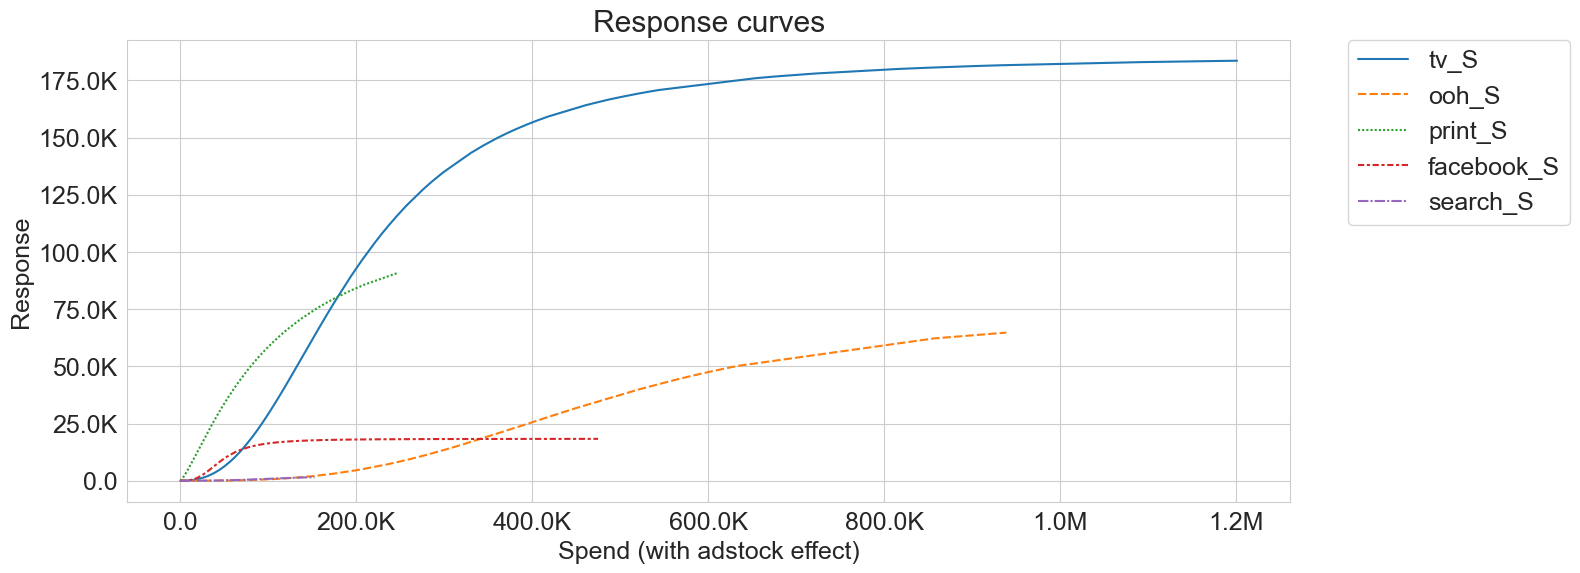

In [71]:
plot_multiple_spend_response_curves(media_spend_response_data)

### Generate Response Curves as Partial Dependence

In [38]:
result["x_input_interval_transformed"].head()

,trend,season,holiday,competitor_sales_B,events,tv_S_hill,ooh_S_hill,print_S_hill,facebook_S_hill,search_S_hill,newsletter_hill
0,2867267.95488,1124162.42188,0.00000,8125009,0.00000,0.39398,0.00000,0.46518,0.98870,0.00000,0.00524
1,2868317.20015,893868.48450,0.00000,7901549,0.00000,0.70200,0.00000,0.12791,0.93561,0.01633,0.00866
2,2869366.44542,710075.08233,0.00000,8300197,0.00000,0.22588,0.11120,0.04256,0.97596,0.01920,0.00969
3,2870415.69069,697323.47594,0.00000,8122883,0.00000,0.95015,0.00012,0.57448,0.96409,0.02632,0.00031
4,2871464.93596,803071.03619,466272.31392,7105985,0.00000,0.70245,0.53963,0.18545,0.80587,0.01831,0.00499


In [39]:
media_features = [f"{media_channel}_hill" for media_channel in media_channels]
media_features

['tv_S_hill', 'ooh_S_hill', 'print_S_hill', 'facebook_S_hill', 'search_S_hill']

In [40]:
temp_data = result["x_input_interval_transformed"].copy()
temp_data[media_features] = 0
zero_spend = result["model"].predict(temp_data).mean()
zero_spend

1725929.8739134062

In [41]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.4220788437765558,
 'ooh_S': 0.10019099066044604,
 'print_S': 0.24678666680117614,
 'facebook_S': 0.38448799550469326,
 'search_S': 0.1405168971027844,
 'newsletter': 0.3515565832936356}

In [42]:
media_spend_response_data.head()

,spend,response,media_channel
0,167687.60000,73274.99652,tv_S
1,285378.28832,130562.82027,tv_S
2,120452.13797,42010.85274,tv_S
3,676717.59913,176714.07757,tv_S
4,285628.18180,130645.24289,tv_S


In [43]:
media_spend_response_partial_dependence = []

for media_feature, media_channel in zip(media_features, media_channels):
    print(f"feature: {media_feature}, channel: {media_channel}")
    other_media_features = list(set(media_features) - {media_feature})
    
    print(f"other_media_features: {other_media_features}")
    adstock_hill_spend = result["x_input_interval_transformed"][media_feature].values
    
    adstock_alpha = experiment.best_trial.user_attrs['adstock_alphas'][media_channel]
    print(f"adstock alpha: {adstock_alpha}")
    
    #copy the dataframe to avoid changing the original dataframe
    temp_data = result["x_input_interval_transformed"].copy()
    temp_data[other_media_features] = 0
    
    original_spend = result["x_input_interval_nontransformed"][media_channel]
    adstock_spend = AdstockGeometric(alpha = adstock_alpha).fit_transform(original_spend)
    
    
    media_response_channel = []
    for spend in adstock_hill_spend:
        temp_data[media_feature] = spend
        
        mean_response = result["model"].predict(temp_data).mean() - zero_spend
        media_response_channel.append(mean_response)
    
    media_response_channel = pd.DataFrame({"spend": adstock_spend, "response": media_response_channel, "media_channel": media_channel})
    media_spend_response_partial_dependence.append(media_response_channel)

media_spend_response_partial_dependence = pd.concat(media_spend_response_partial_dependence).reset_index(drop=True)

feature: tv_S_hill, channel: tv_S
other_media_features: ['print_S_hill', 'facebook_S_hill', 'search_S_hill', 'ooh_S_hill']
adstock alpha: 0.4220788437765558
feature: ooh_S_hill, channel: ooh_S
other_media_features: ['tv_S_hill', 'print_S_hill', 'facebook_S_hill', 'search_S_hill']
adstock alpha: 0.10019099066044604
feature: print_S_hill, channel: print_S
other_media_features: ['tv_S_hill', 'facebook_S_hill', 'search_S_hill', 'ooh_S_hill']
adstock alpha: 0.24678666680117614
feature: facebook_S_hill, channel: facebook_S
other_media_features: ['print_S_hill', 'tv_S_hill', 'search_S_hill', 'ooh_S_hill']
adstock alpha: 0.38448799550469326
feature: search_S_hill, channel: search_S
other_media_features: ['tv_S_hill', 'print_S_hill', 'facebook_S_hill', 'ooh_S_hill']
adstock alpha: 0.1405168971027844


In [44]:
media_spend_response_partial_dependence

,spend,response,media_channel
0,167687.60000,73274.99652,tv_S
1,285378.28832,130562.82027,tv_S
2,120452.13797,42010.85274,tv_S
3,676717.59913,176714.07757,tv_S
4,285628.18180,130645.24289,tv_S
...,...,...,...
1035,130821.00000,1305.08371,search_S
1036,122082.00000,1182.94010,search_S
1037,131854.00000,1318.87059,search_S
1038,152627.00000,1565.17923,search_S


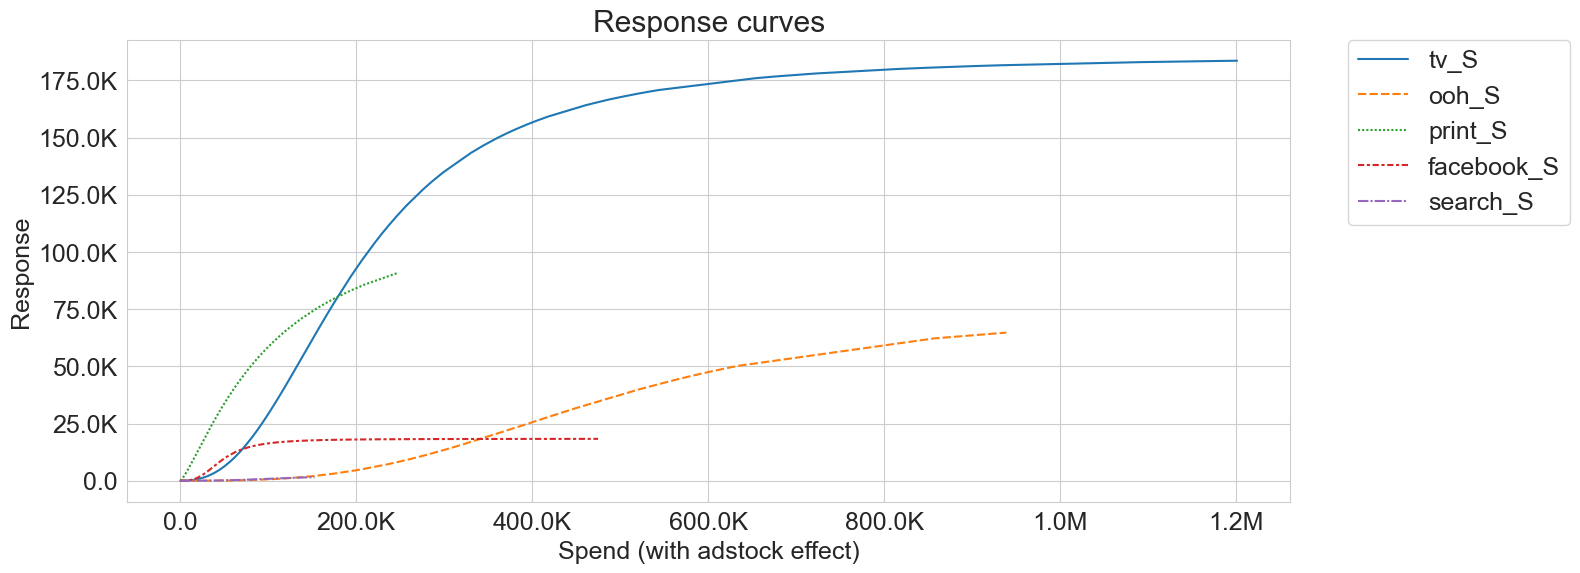

In [82]:
plot_multiple_spend_response_curves(media_spend_response_partial_dependence)

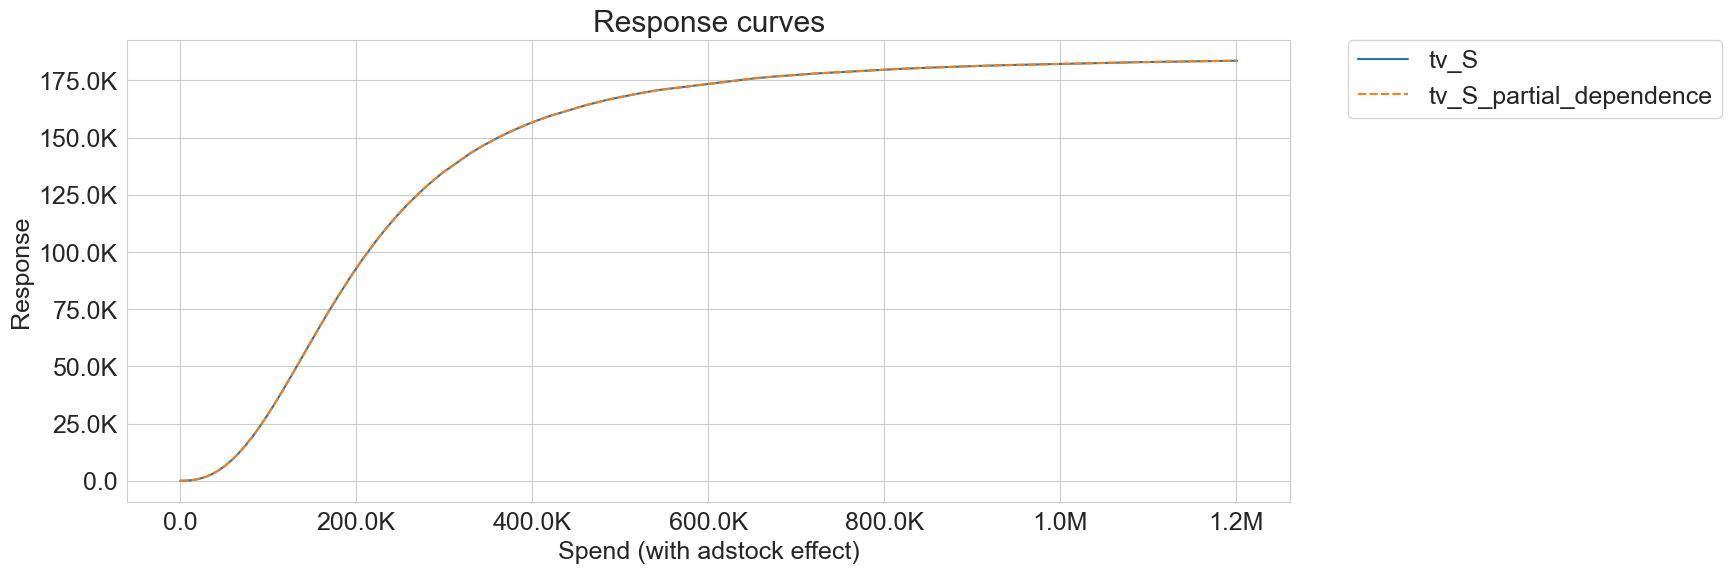

None


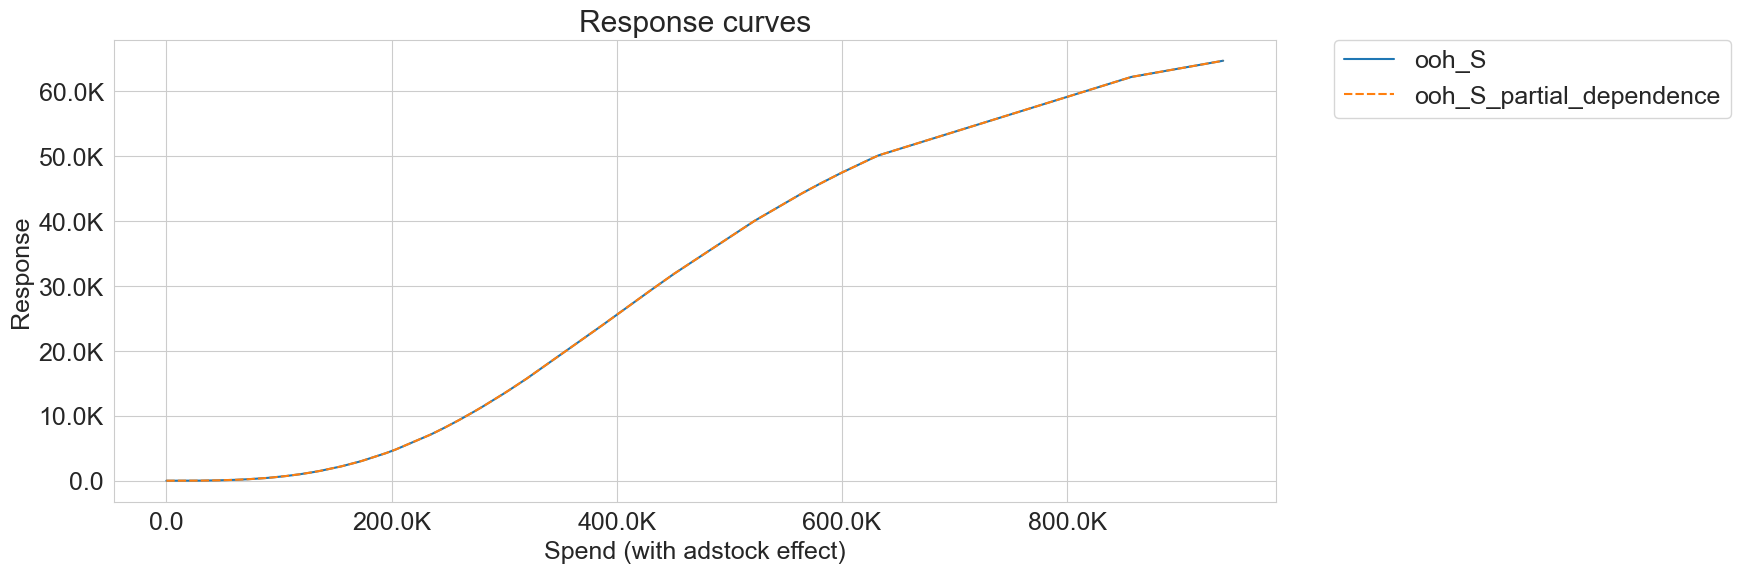

None


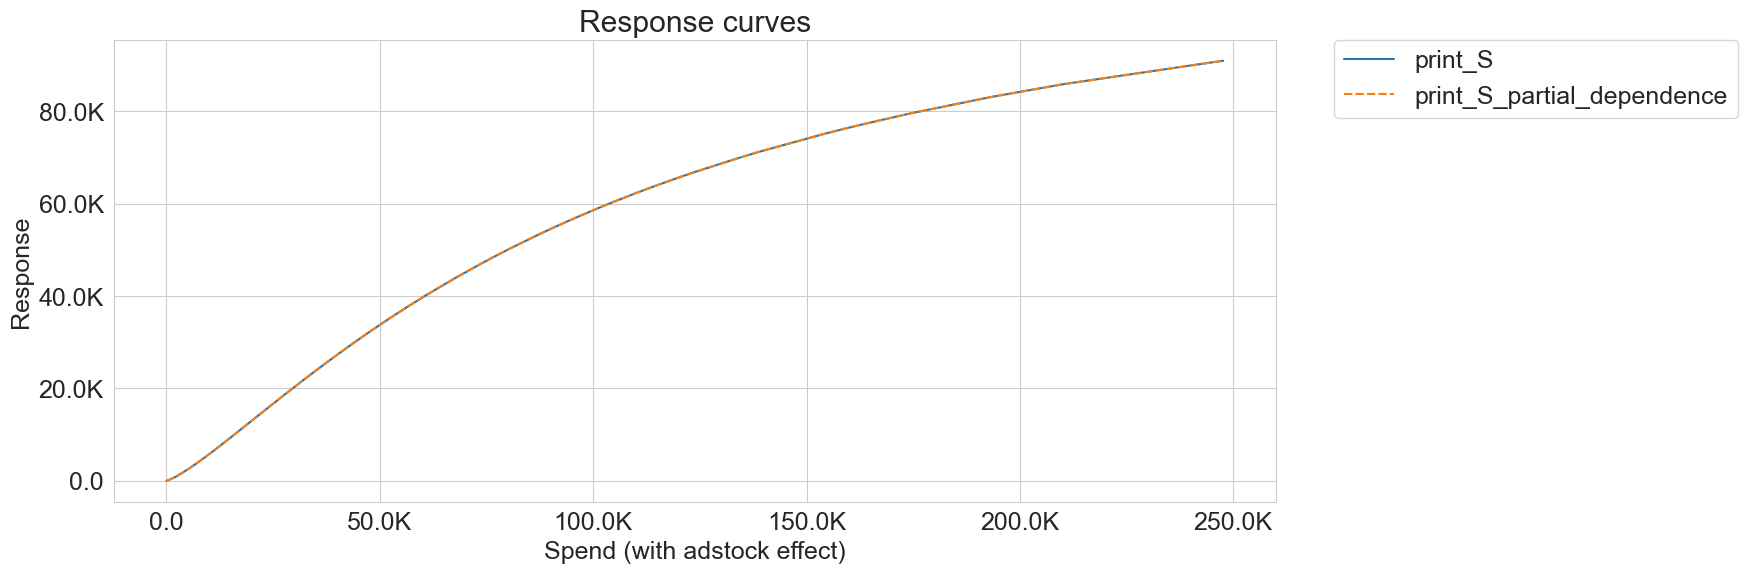

None


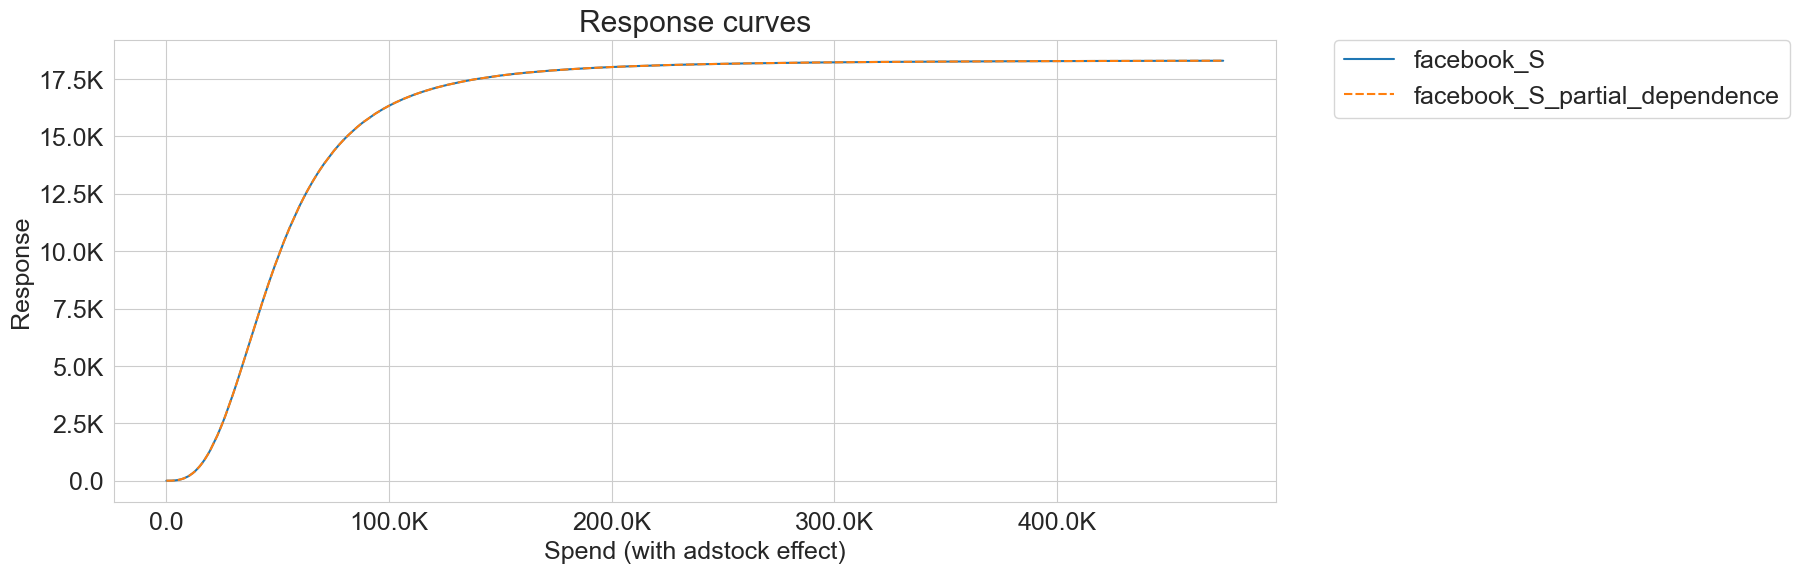

None


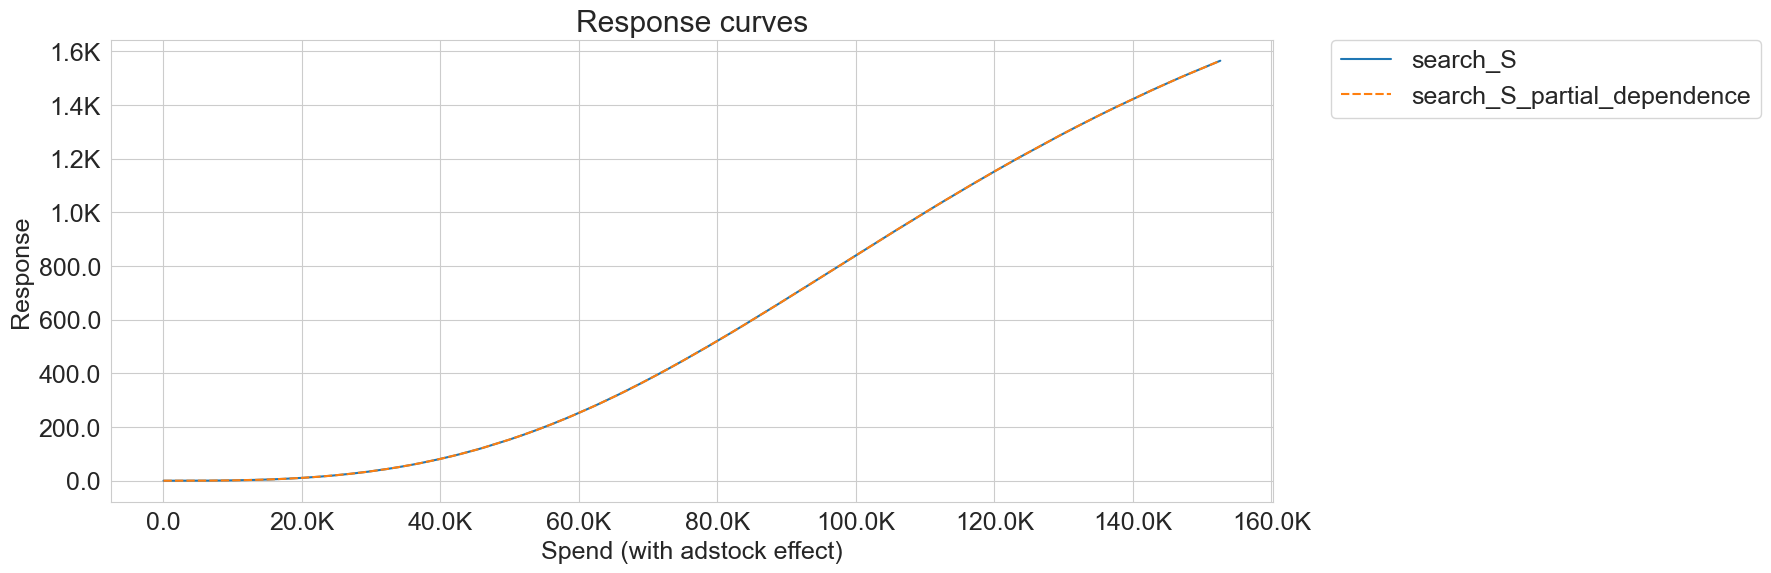

None


In [84]:
# sourcery skip: for-index-underscore
for media_channel in media_channels:
    temp_data = media_spend_response_partial_dependence.query("media_channel == @media_channel").copy()
    temp_data["media_channel"] = temp_data["media_channel"] + "_partial_dependence"
    temp_data = pd.concat([media_spend_response_data.query("media_channel == @media_channel"), temp_data])
    print(plot_multiple_spend_response_curves(temp_data))

## Modeling ML (Lightgbm)

### Helper functions

In [85]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def shap_feature_importance(shap_values, data, figsize = (20, 10)):
    
    feature_list = data.columns

    if not isinstance(shap_values, pd.DataFrame):
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values


    df_v = data.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = []
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
def plot_shap_vs_spend(df_shap_values, 
                       x_input_interval_nontransformed, 
                       x_input_interval_transformed, 
                       features, 
                       media_channels, 
                       figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        
        ax.xaxis.set_major_formatter(
            mtick.FuncFormatter(format_thousands_millions)
        )
        
        plt.legend()   
    
def model_ml_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[:end_index][features].copy()
    y_true_all = data[target].values[:end_index]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_input, y_true_all)

    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)}")
    prediction = model.predict(x_input_interval_transformed)

    #transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    #shap explainer 
    explainer = shap.TreeExplainer(model)

    # get SHAP values for the data set for the analysis interval from explainer model
    shap_values_train = explainer.shap_values(x_input_interval_transformed)

    # create a dataframe of the shap values for the training set and the test set
    df_shap_values = pd.DataFrame(shap_values_train, columns=features)

    return {
            'df_shap_values': df_shap_values, 
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval, 
            "model": model
           }

In [48]:
def optuna_ml_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 media_features, 
                 is_monotone, 
                 is_random_forest,
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}

    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha

        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_temp[feature] = temp_adstock



    boosting_type = "rf" if is_random_forest else "gbdt"
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    subsample_freq = 1
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)




    #find indices of media channels for the monotonic constraint parameter
    monotone_constraints = np.zeros((len(features), ))
    for media_feature in media_features:
        if is_monotone:
            ind = features.index(media_feature)
            monotone_constraints[ind] = 1
    ###keep scores
    scores = []


    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]

        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]

    
        params = {
            "boosting_type" : boosting_type,
            "n_estimators"  : n_estimators,
            "subsample"     : subsample,
            "subsample_freq": subsample_freq,
            "colsample_bytree": colsample_bytree,
            "monotone_constraints": ",".join(str(ind) for ind in monotone_constraints)
        }

        model = lgb.LGBMRegressor(**params)
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)

        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)


    trial.set_user_attr("scores", scores)

    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)


    return np.mean(scores)

In [49]:
def optuna_ml_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    media_features, 
                    is_monotone,
                    is_random_forest,
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_ml_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    media_features = media_features, 
                                    is_monotone = is_monotone,
                                    is_random_forest = is_random_forest,
                                    tscv = tscv)
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm
    

In [50]:

tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

adstock_features_params = {
    "tv_S_adstock": (0.3, 0.8),
    "ooh_S_adstock": (0.1, 0.4),
    "print_S_adstock": (0.1, 0.4),
    "facebook_S_adstock": (0.1, 0.4),
    "search_S_adstock": (0.1, 0.4),
    "newsletter_adstock": (0.1, 0.4),
}
OPTUNA_TRIALS = 2000

IS_MONOTONE = True
IS_RANDOM_FOREST = False

experiment_ml = optuna_ml_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             is_monotone = IS_MONOTONE,
                             is_random_forest=IS_RANDOM_FOREST,
                             tscv = tscv)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/2000 [00:00<?, ?it/s]

### Model Refit

In [51]:
best_params = experiment_ml.best_trial.user_attrs["params"]
best_params

{'boosting_type': 'gbdt',
 'n_estimators': 81,
 'subsample': 0.6971390688944429,
 'subsample_freq': 1,
 'colsample_bytree': 0.7574621191991912,
 'monotone_constraints': '0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0'}

In [52]:
adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"]
adstock_params

{'tv_S': 0.3174818226189306,
 'ooh_S': 0.30325660352853645,
 'print_S': 0.27919717674031397,
 'facebook_S': 0.39060129413345823,
 'search_S': 0.17940280519559143,
 'newsletter': 0.3208032426366761}

In [53]:
best_params = experiment_ml.best_trial.user_attrs["params"]
adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"]
result_ml = model_ml_refit(data = data, 
                            target = target,
                            features = features, 
                            media_channels = media_channels, 
                            organic_channels = organic_channels, 
                            model_params = best_params, 
                            adstock_params = adstock_params, 
                            start_index = 0, 
                            end_index = data.shape[0])

applying geometric adstock transformation on tv_S with alpha 0.3174818226189306
applying geometric adstock transformation on ooh_S with alpha 0.30325660352853645
applying geometric adstock transformation on print_S with alpha 0.27919717674031397
applying geometric adstock transformation on facebook_S with alpha 0.39060129413345823
applying geometric adstock transformation on search_S with alpha 0.17940280519559143
applying geometric adstock transformation on newsletter with alpha 0.3208032426366761
predicting 208


### Metrics

RMSE: 160870.26387996666
MAPE: 0.05911703813759561


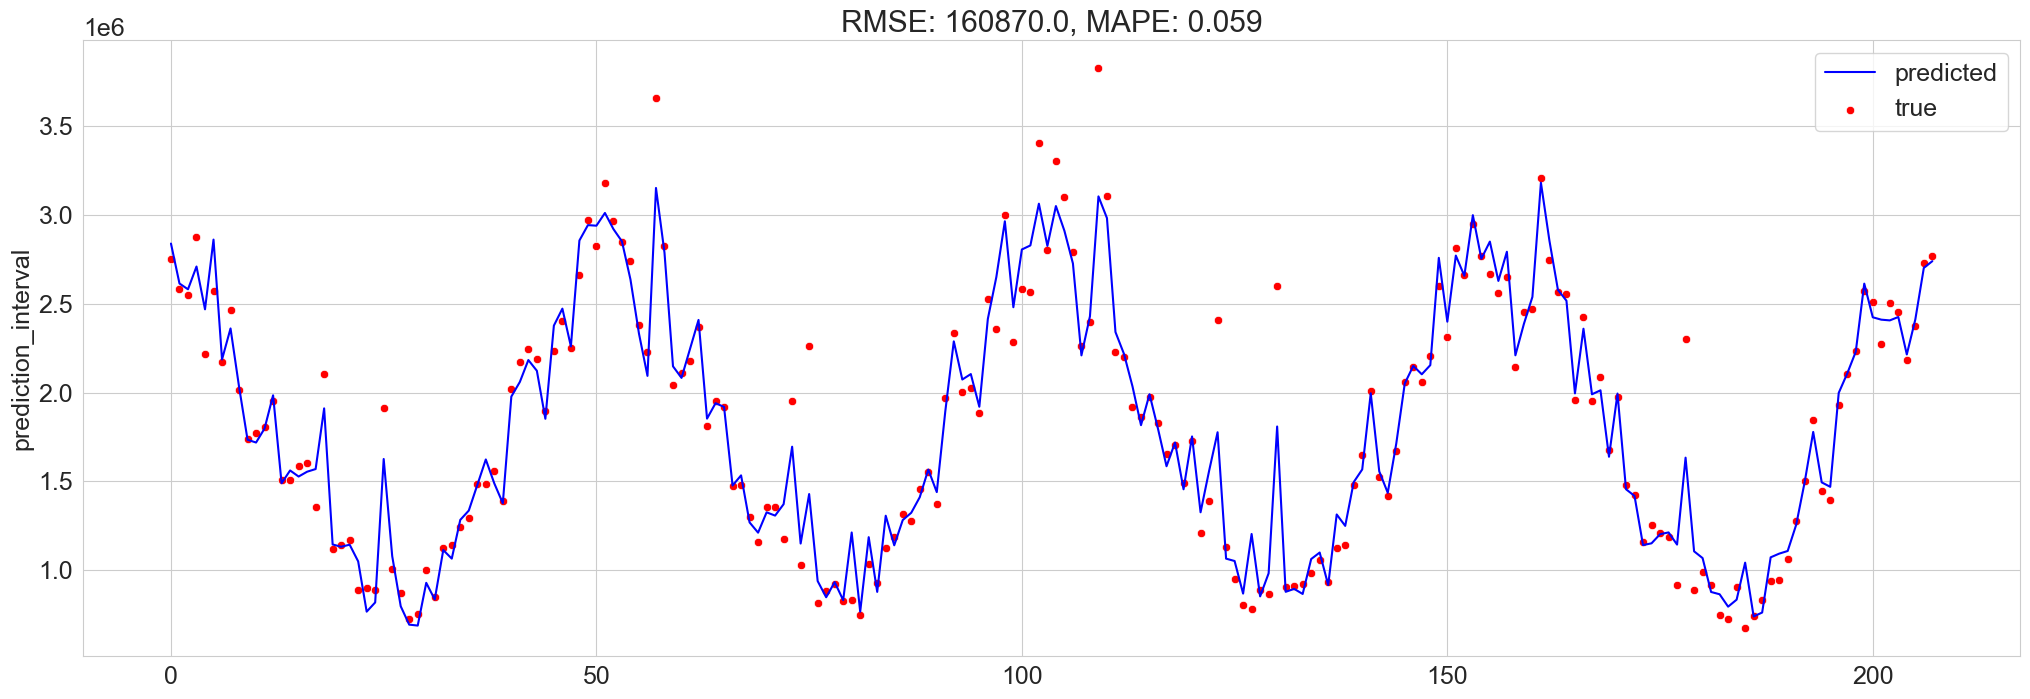

In [54]:
rmse_metric = mean_squared_error(y_true = result_ml["y_true_interval"], y_pred = result_ml["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result_ml["y_true_interval"], y_pred = result_ml["prediction_interval"])


print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')



fig, ax = plt.subplots(figsize=(25, 8))
sns.lineplot(data=result_ml, x = range(len(result_ml["prediction_interval"])), y='prediction_interval', color='blue', label='predicted', ax=ax)
sns.scatterplot(data=result_ml, x=range(len(result_ml["y_true_interval"])), y='y_true_interval', color='red', marker='o', label='true', ax=ax)
plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}")
_ = plt.legend()


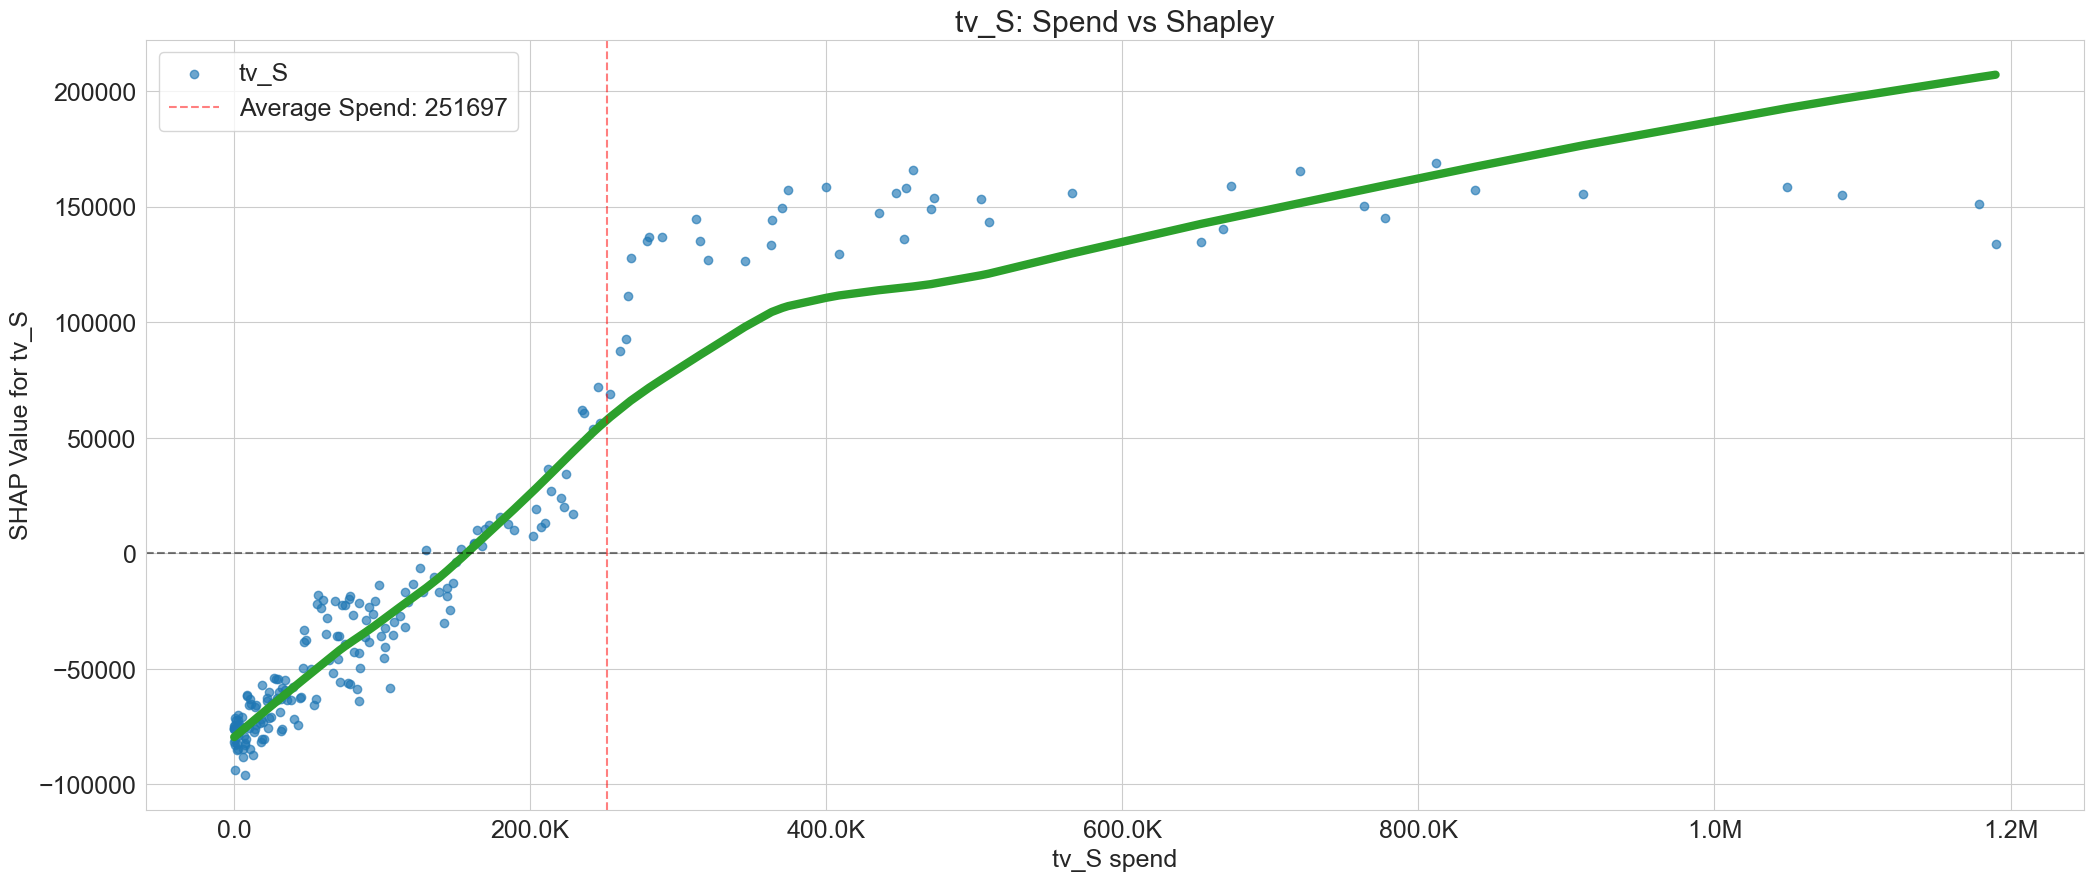

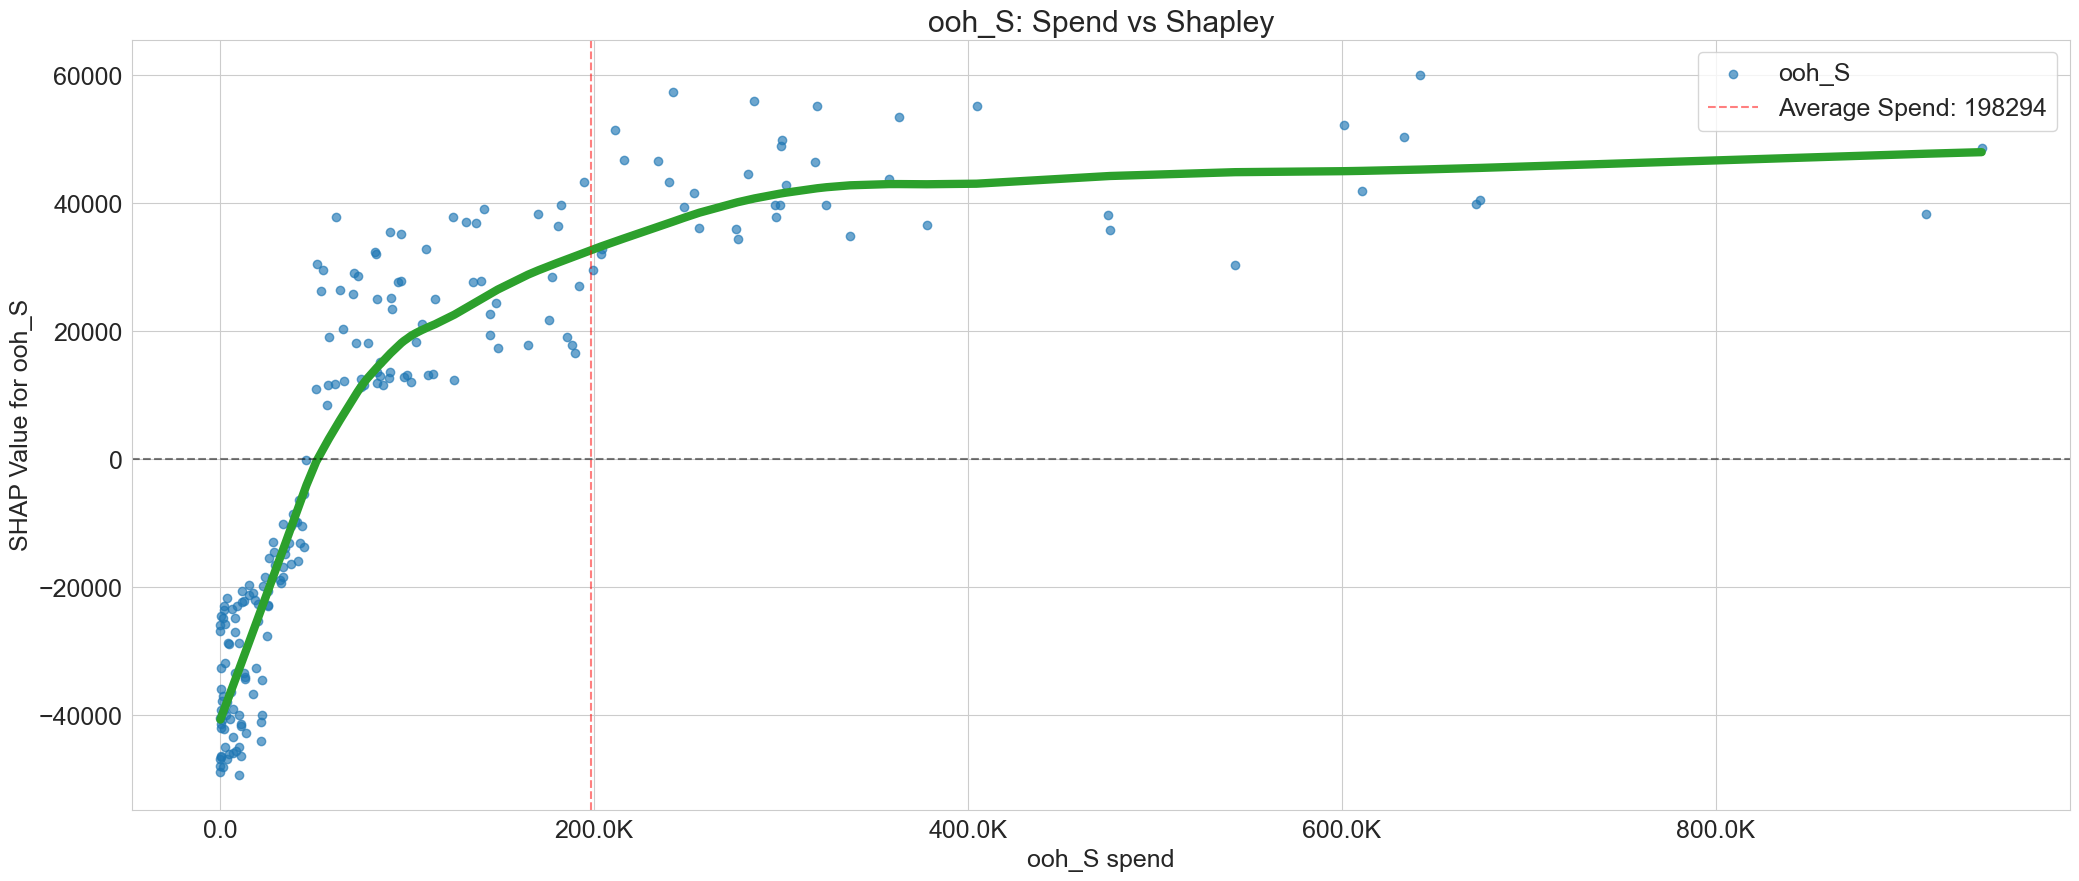

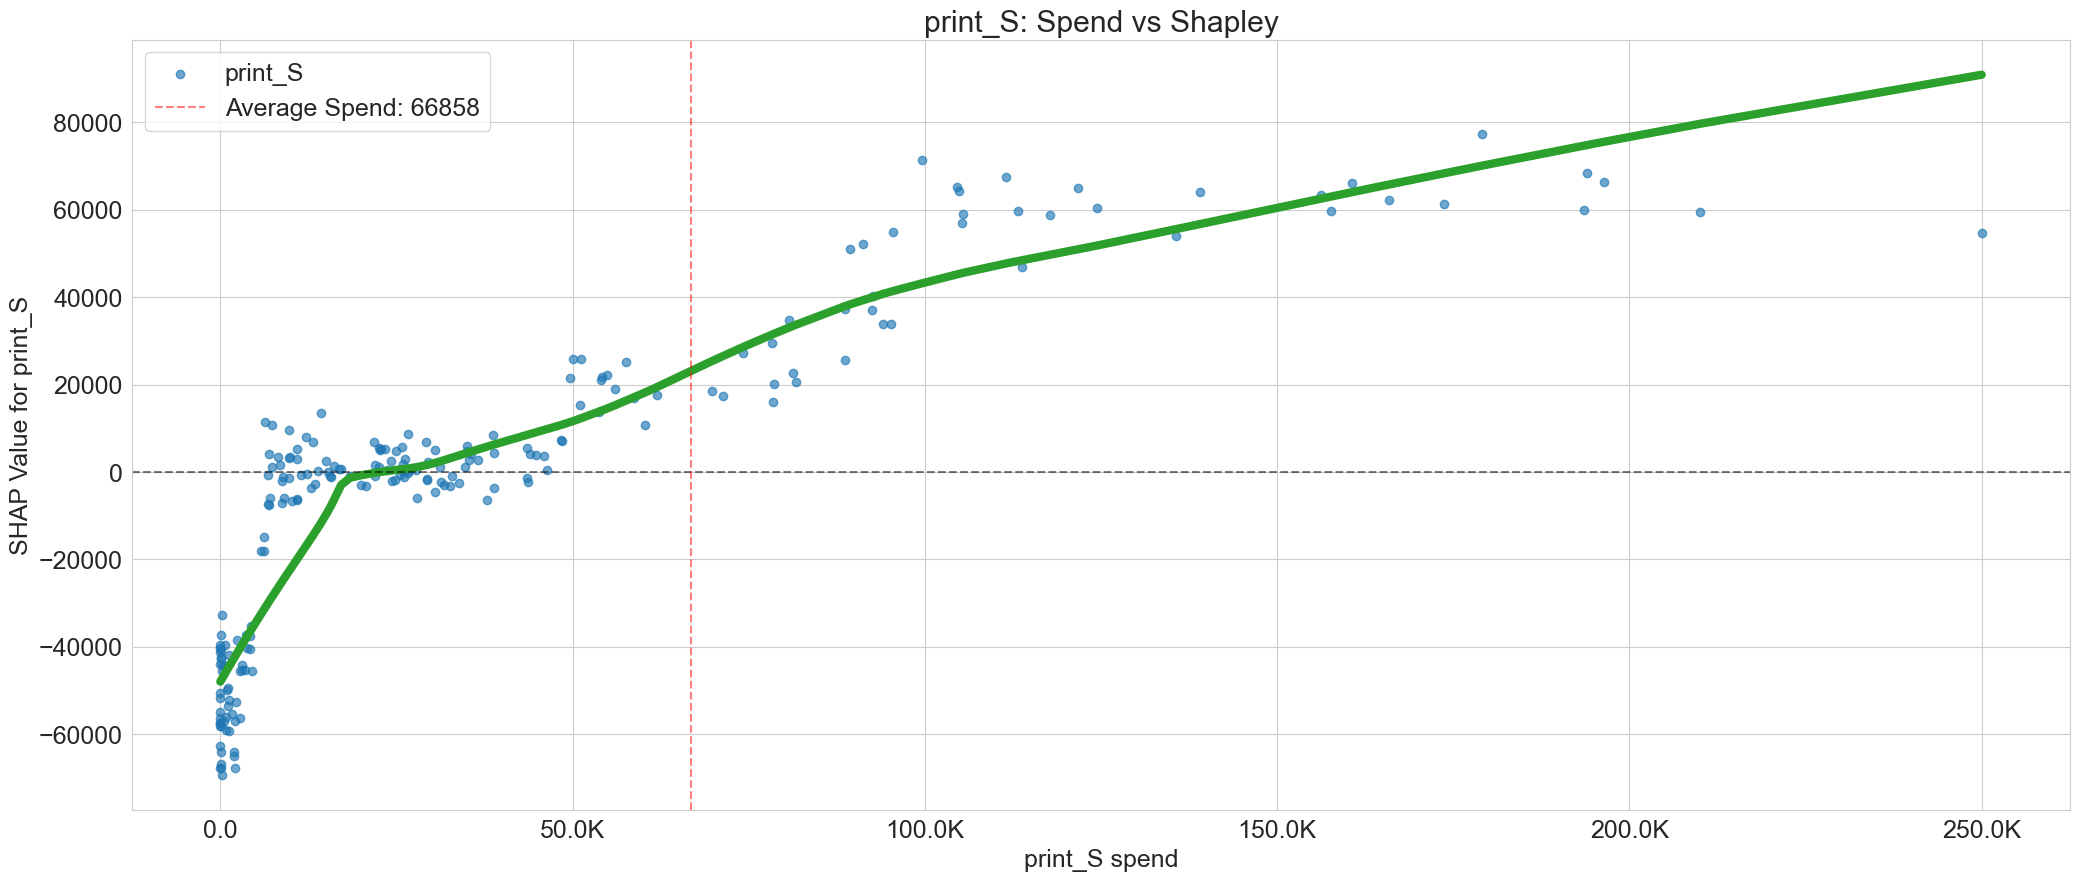

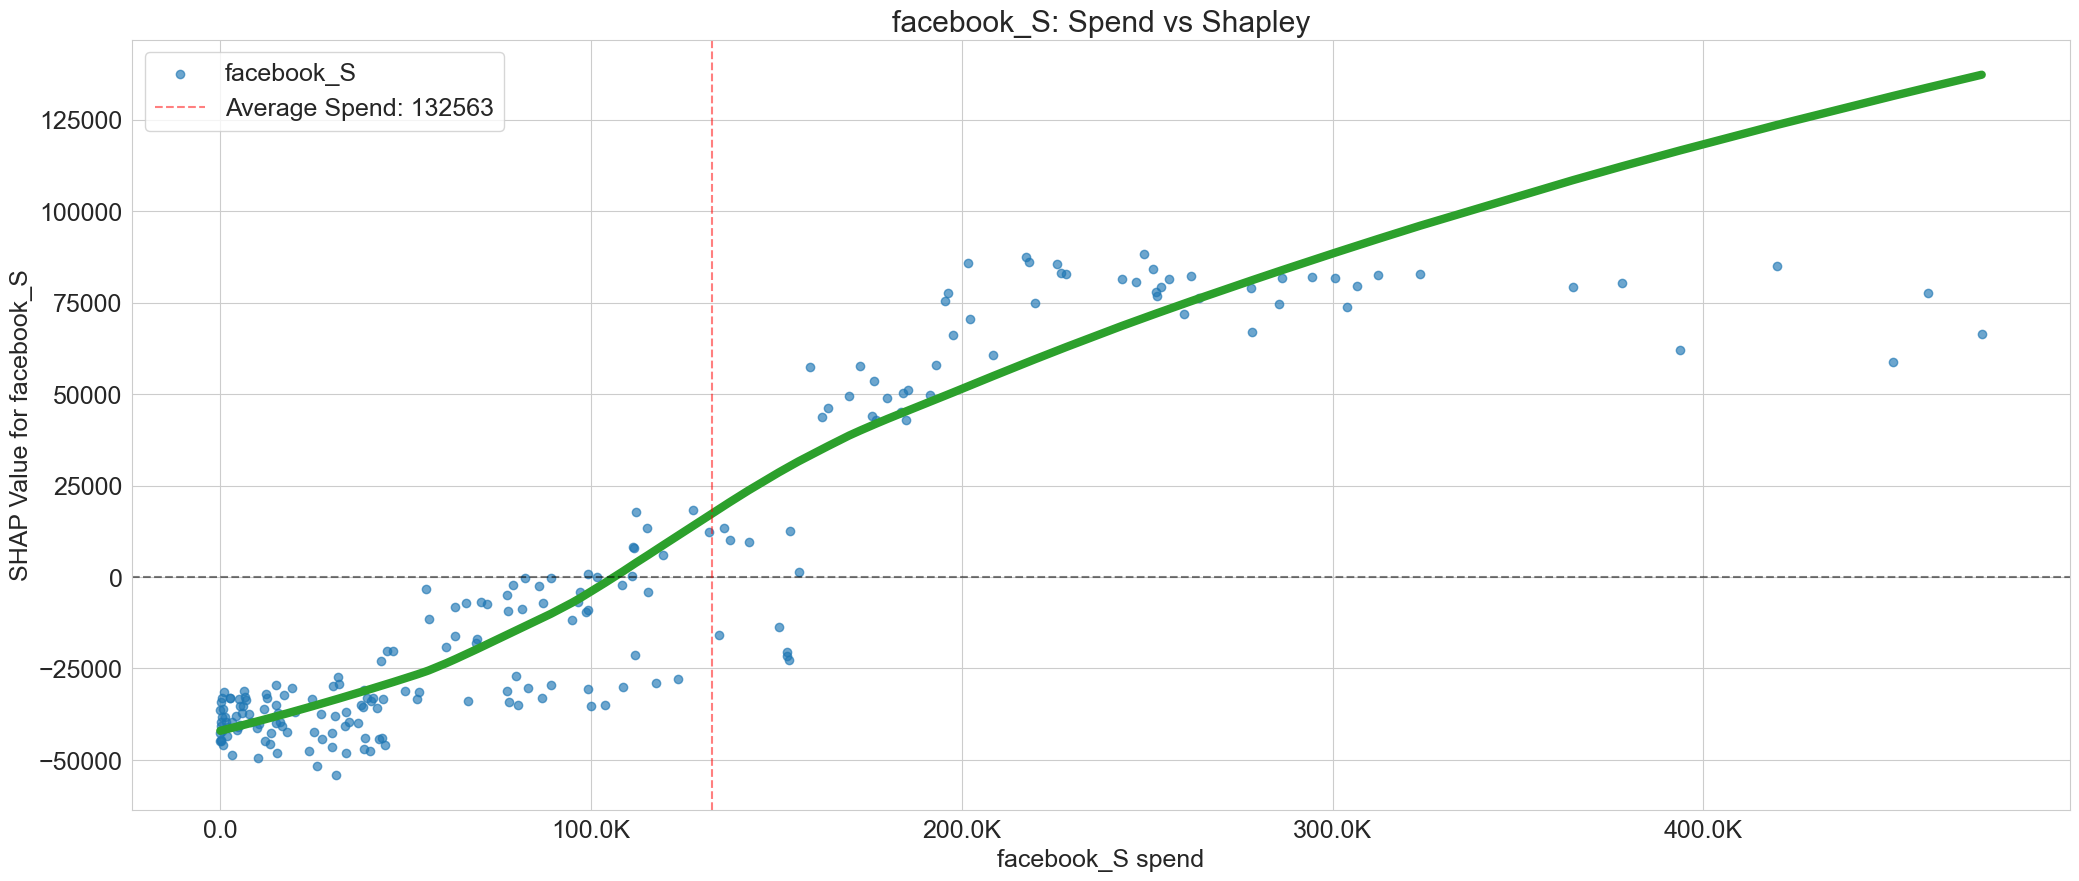

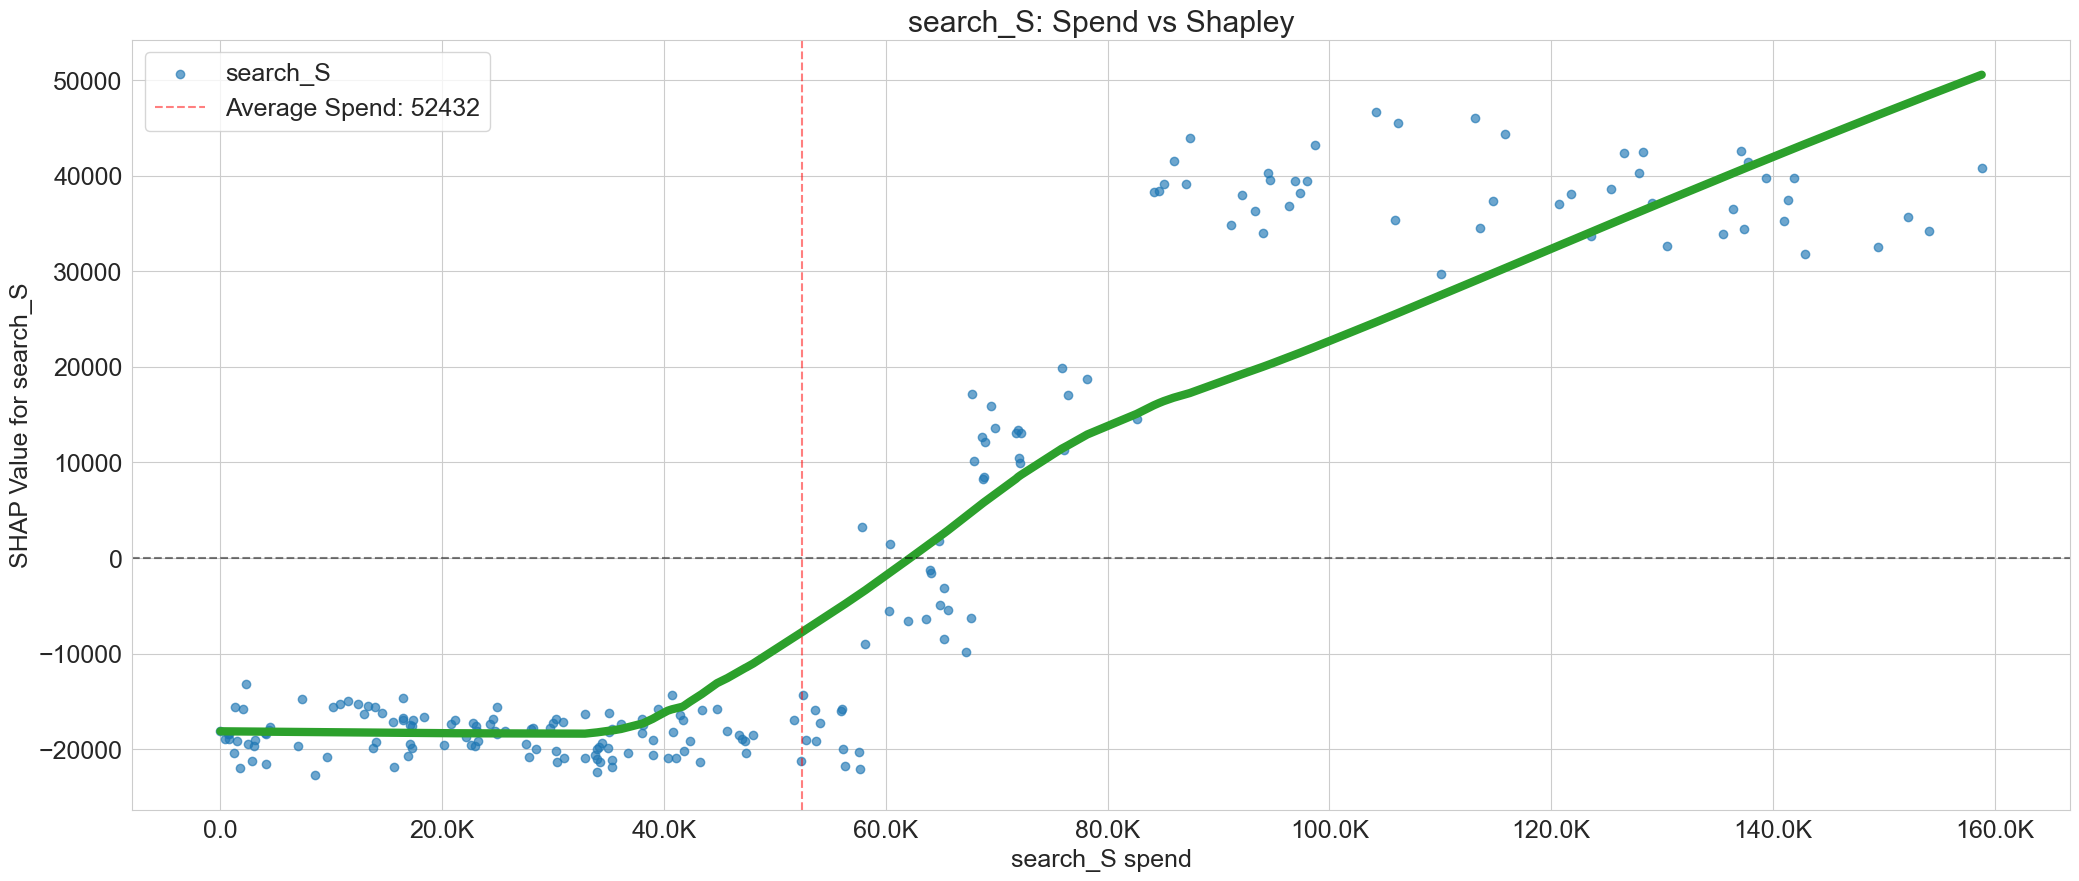

In [86]:
plot_shap_vs_spend(result_ml["df_shap_values"], 
                   result_ml["x_input_interval_nontransformed"], 
                   result_ml["x_input_interval_transformed"], 
                   features, 
                   media_channels)

### Generate Response Curves as Partial Dependence

In [56]:
result_ml["x_input_interval_nontransformed"].head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,trend,season,holiday
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,0.00000,19401.65385,2867267.95488,1124162.42188,0.00000
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,0.00000,14791.00000,2868317.20015,893868.48450,0.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,0.00000,14544.00000,2869366.44542,710075.08233,0.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,0.00000,2800.00000,2870415.69069,697323.47594,0.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,0.00000,15478.00000,2871464.93596,803071.03619,466272.31392


In [57]:
result_ml["x_input_interval_transformed"].head()

,trend,season,holiday,competitor_sales_B,events,tv_S,ooh_S,print_S,facebook_S,search_S,newsletter
0,2867267.95488,1124162.42188,0.00000,8125009,0.00000,167687.60000,0,95463.66667,228213.98744,0,19401.65385
1,2868317.20015,893868.48450,0.00000,7901549,0.00000,267838.66488,0,26653.18621,123399.25235,31000,21015.11347
2,2869366.44542,710075.08233,0.00000,8300197,0.00000,85033.90749,248022,10845.49434,175891.16900,33961,21285.71654
3,2870415.69069,697323.47594,0.00000,8122883,0.00000,652874.01994,75214,135628.03140,152718.03854,37992,9628.52689
4,2871464.93596,803071.03619,466272.31392,7105985,0.00000,207275.63379,542814,37866.96345,80339.34165,33915,18566.86265


In [58]:
temp_data = result_ml["x_input_interval_transformed"].copy()
temp_data[media_channels] = 0
zero_spend = result_ml["model"].predict(temp_data).mean()
zero_spend

1589368.6459341499

In [59]:
media_spend_response_partial_dependence_ml = []

for media_channel in media_channels:
    print(f"channel: {media_channel}")
    other_media_features = list(set(media_channels) - {media_channel})
    
    print(f"other_media_features: {other_media_features}")
    adstock_transformed_spend = result_ml["x_input_interval_transformed"][media_channel].values
    
    adstock_alpha = adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"][media_channel]
    print(f"adstock alpha: {adstock_alpha}")
    
    #copy the dataframe to avoid changing the original dataframe
    temp_data = result_ml["x_input_interval_transformed"].copy()
    temp_data[other_media_features] = 0
    
    original_spend = result_ml["x_input_interval_nontransformed"][media_channel]
    adstock_spend = AdstockGeometric(alpha = adstock_alpha).fit_transform(original_spend)
    
    
    media_response_channel = []
    for spend in adstock_transformed_spend:
        temp_data[media_channel] = spend
        
        mean_response = result_ml["model"].predict(temp_data).mean() - zero_spend
        media_response_channel.append(mean_response)
    
    media_response_channel = pd.DataFrame({"spend": adstock_spend, "response": media_response_channel, "media_channel": media_channel})
    media_spend_response_partial_dependence_ml.append(media_response_channel)

media_spend_response_partial_dependence_ml = pd.concat(media_spend_response_partial_dependence_ml).reset_index(drop=True)

channel: tv_S
other_media_features: ['ooh_S', 'search_S', 'facebook_S', 'print_S']
adstock alpha: 0.3174818226189306
channel: ooh_S
other_media_features: ['tv_S', 'search_S', 'facebook_S', 'print_S']
adstock alpha: 0.30325660352853645
channel: print_S
other_media_features: ['tv_S', 'ooh_S', 'search_S', 'facebook_S']
adstock alpha: 0.27919717674031397
channel: facebook_S
other_media_features: ['tv_S', 'ooh_S', 'search_S', 'print_S']
adstock alpha: 0.39060129413345823
channel: search_S
other_media_features: ['tv_S', 'ooh_S', 'facebook_S', 'print_S']
adstock alpha: 0.17940280519559143


In [60]:
media_spend_response_partial_dependence_ml

,spend,response,media_channel
0,167687.60000,96296.71882,tv_S
1,267838.66488,220271.49050,tv_S
2,85033.90749,54811.84442,tv_S
3,652874.01994,241931.03034,tv_S
4,207275.63379,107889.76074,tv_S
...,...,...,...
1035,137108.00000,59296.14475,search_S
1036,128297.00000,59296.14475,search_S
1037,137716.00000,59296.14475,search_S
1038,158806.00000,59296.14475,search_S


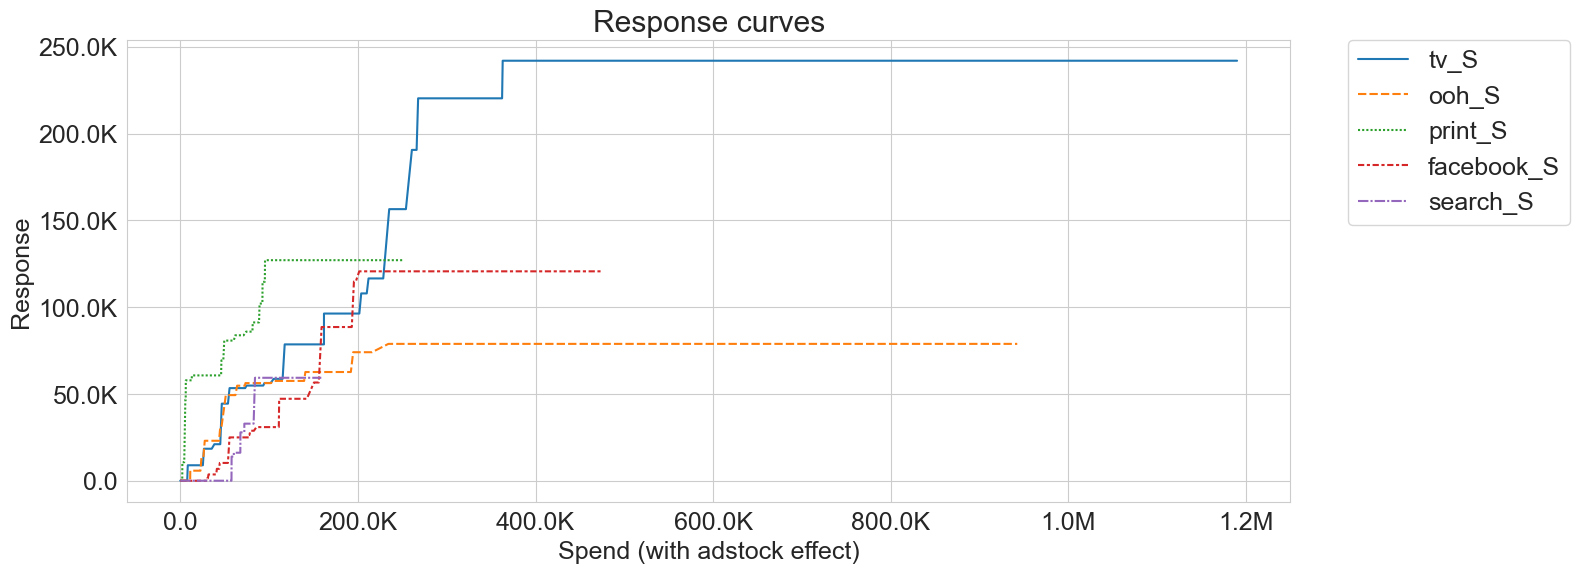

In [87]:
plot_multiple_spend_response_curves(media_spend_response_partial_dependence_ml)

In [62]:
media_spend_response_partial_dependence_ml

,spend,response,media_channel
0,167687.60000,96296.71882,tv_S
1,267838.66488,220271.49050,tv_S
2,85033.90749,54811.84442,tv_S
3,652874.01994,241931.03034,tv_S
4,207275.63379,107889.76074,tv_S
...,...,...,...
1035,137108.00000,59296.14475,search_S
1036,128297.00000,59296.14475,search_S
1037,137716.00000,59296.14475,search_S
1038,158806.00000,59296.14475,search_S


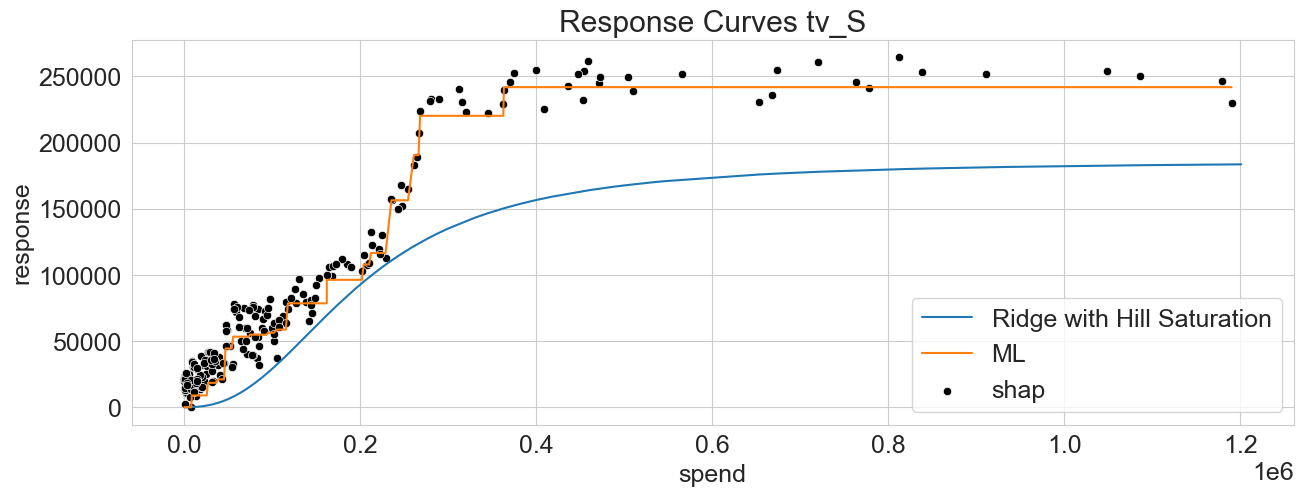

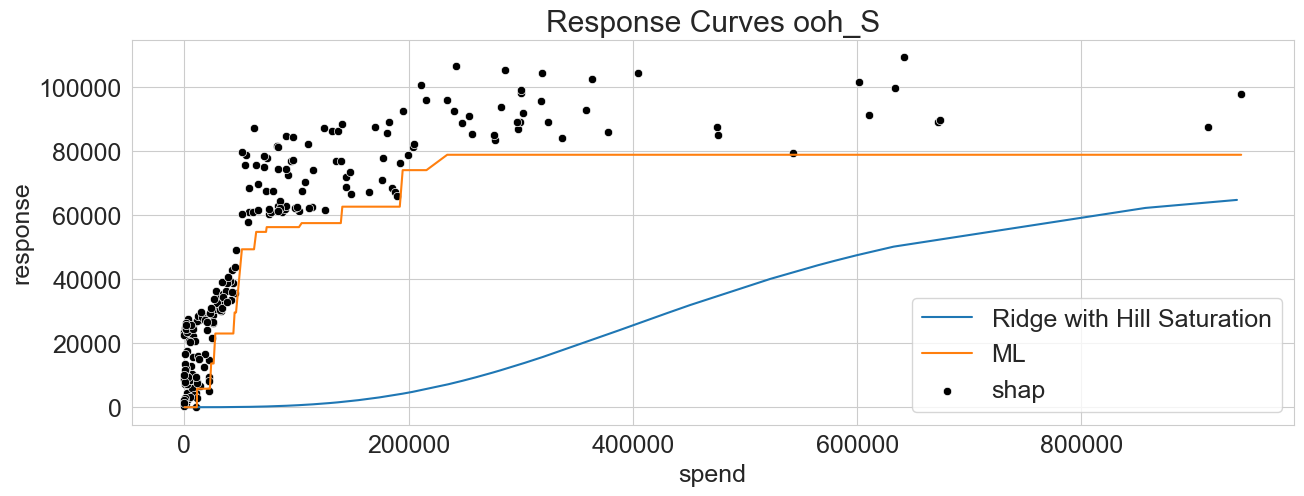

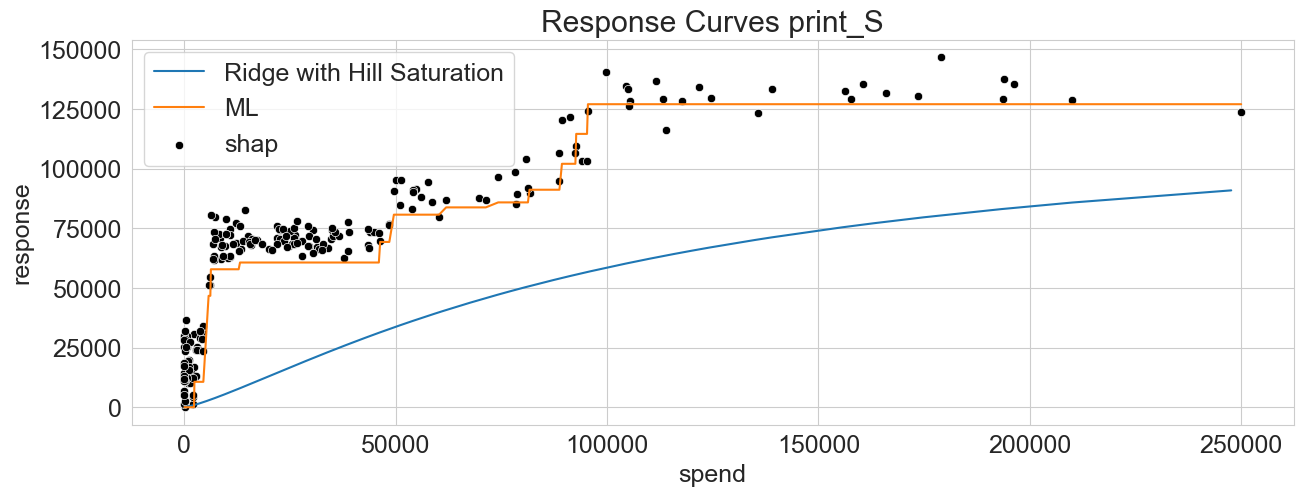

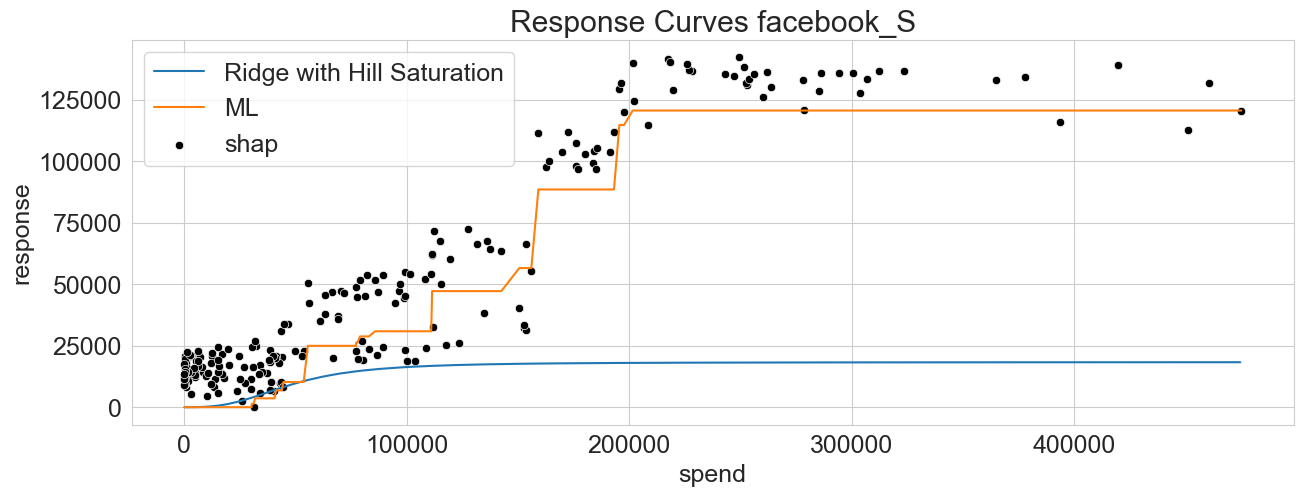

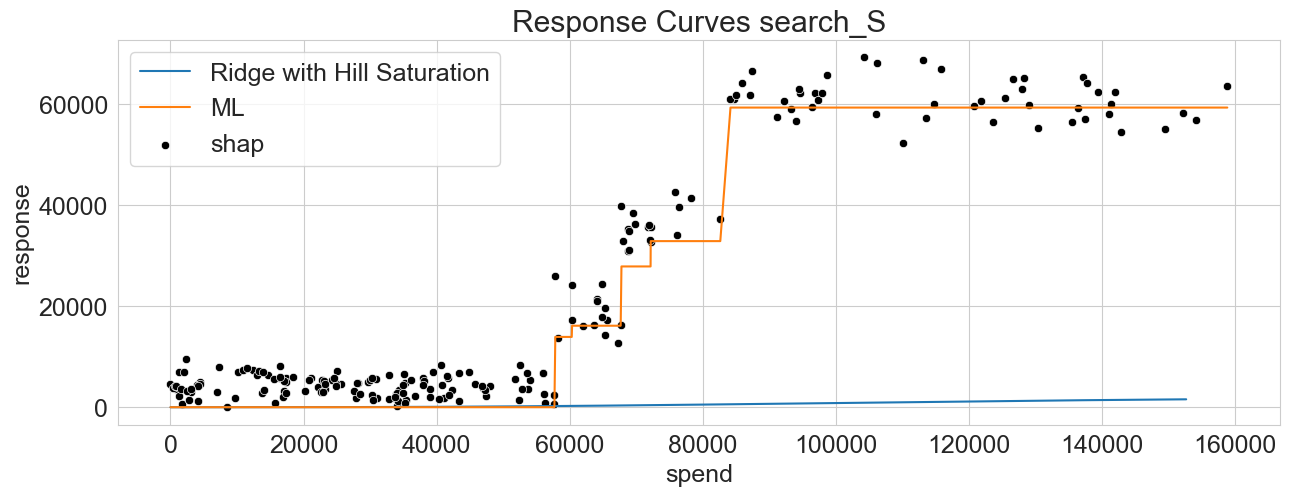

In [63]:
#difference between ml and ridge
for channel in media_channels:

    f, axs = plt.subplots(1, 1, figsize=(15, 5))


    channel_spend_adstock = result_ml["x_input_interval_transformed"][channel]
    channel_shap = result_ml["df_shap_values"][channel]


    chart = sns.lineplot(data = media_spend_response_partial_dependence.query("media_channel == @channel"), x = "spend", y = "response", label = "Ridge with Hill Saturation", ax = axs)
    sns.lineplot(data = media_spend_response_partial_dependence_ml.query("media_channel == @channel"), x = "spend", y = "response", label = "ML", ax = axs)
    sns.scatterplot(x = channel_spend_adstock, y = channel_shap + abs(channel_shap.min()), label = "shap", color = "black", ax = axs)
    axs.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    axs.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    chart.set_title(f"Response Curves {channel}")